In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import sys
from tqdm import tqdm
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/psix_project/psix/psix/')
import psix

cm = 1/2.54

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["axes.facecolor"] = 'white'

import matplotlib as mpl
import numpy as np

mpl.rcParams["mathtext.fontset"] = "stix"
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
psix_object = psix.Psix()
psix_object.process_rnaseq(
        'data/preprocess/tables/SE_counts_filtered.tab.gz',
        'data/preprocess/tables/constitutive_introns_filtered.tab.gz',
        'data/preprocess/tables/rsem_gene_tpm_filtered.tab.gz',
        minJR = 1,
        minCell=1,
        min_observed = 0.25)

Obtaining PSI tables...
Reading TPM and transforming to mRNA counts...


100%|██████████| 1067/1067 [00:46<00:00, 22.88it/s]


Successfully processed RNA-seq data


In [3]:
psix_object.compute_psix_scores(latent='data/preprocess/tables/pc3_rd.tab.gz', n_jobs=25, 
                                n_random_exons=2000, n_neighbors=100)


Computing cell-cell metric...


100%|██████████| 1067/1067 [00:00<00:00, 2702.40it/s]

Successfully computed cell-cell metric
Computing Psix score in 2087 exons



100%|██████████| 2087/2087 [00:20<00:00, 103.15it/s]


Successfully computed Psix score of exons.
Estimating p-values. This might take a while...


100%|██████████| 25/25 [08:32<00:00, 20.52s/it]  


Successfully estimated p-values


In [4]:
psix_results = psix_object.psix_results
psix_results.head(10)

,psix_score,pvals,qvals
Mapt_1,2.709381,0.0005,0.001879
Ndrg4_1,2.359093,0.0005,0.001879
Dbn1_1,2.302729,0.0005,0.001879
Mapt_3,1.964202,0.0005,0.001879
Gabrg2_1,1.896363,0.0005,0.001879
Cadm1_10,1.576869,0.0005,0.001879
Ncam1_6,1.456006,0.0005,0.001879
Dst_5,1.449287,0.0005,0.001879
Cadm1_3,1.411169,0.0005,0.001879
Morf4l2_7,1.363965,0.0005,0.001879


In [5]:
psix_object.compute_neighbors_psi(latent='data/preprocess/tables/pc3_rd.tab.gz', n_neighbors=100)

Successfully computed neighbors


In [6]:
psix_object.compute_modules(min_gene_threshold=30)

In [7]:
psix_object.modules.unique()

array([ 1,  2,  9,  3,  4,  7,  8,  5,  6, 10, -1])

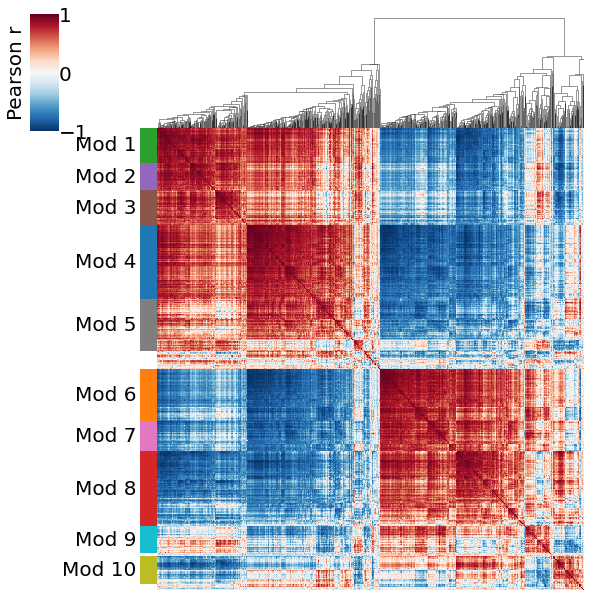

In [8]:
aver = psix_object.plot_correlation_modules()

In [9]:
aver

,Modules
Slc30a9_1,1
Slc30a9_2,1
Cnot2_nmdSE_1,1
Cnot2_nmdSE_2,1
Xpa_nmdSE_1,1
...,...
Mrpl55_1,11
Trub2_2,11
Ndufaf6_2,11
Ncald_7,11


In [6]:
psix_results = psix_object.psix_results
psix_results.head()

,psix_score,pvals,qvals
Mapt_1,2.709381,0.0005,0.001879
Ndrg4_1,2.359093,0.0005,0.001879
Dbn1_1,2.302729,0.0005,0.001879
Mapt_3,1.964202,0.0005,0.001879
Gabrg2_1,1.896363,0.0005,0.001879


In [5]:
psix_results_old = pd.read_csv('psix_3D/psix_results.tab.gz', sep='\t', index_col=0)
np.sum(np.abs(psix_results.psix_score - psix_results_old.psix_score))

6.921777909142061e-15

In [6]:
psix_object.adata.uns['psi'].T.to_csv('data/preprocess/tables/psi_3D.tab.gz', sep='\t', index=True, header=True)
psix_object.adata.uns['mrna_per_event'].T.to_csv('data/preprocess/tables/mrna_per_event_3D.tab.gz', 
                                                 sep='\t', index=True, header=True)

# psix_results = pd.read_csv('psix_3D/psix_results.tab.gz', sep='\t', index_col=0)


100%|██████████| 2087/2087 [00:12<00:00, 171.04it/s]


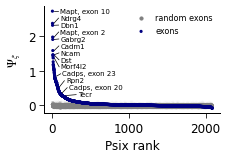

In [7]:
%matplotlib inline

psix_results = psix_object.psix_results.copy()
psix_results['bins'] = ['']*len(psix_results.index)

for mean in psix_object.bins.keys():
    for var in psix_object.bins[mean].keys():
        for exon in psix_object.bins[mean][var]:
            psix_results.loc[exon, 'bins'] = mean +'_' + var
            
fig = plt.figure(figsize=(8*cm, 5*cm))
ax  = plt.subplot(1,1,1)
i = 1

ax.scatter([100], [-0.05], c='gray', label='random exons', s=10)

for mean_var in tqdm(psix_results.sort_values('psix_score')[::-1].bins):
    mean = mean_var[:6]
    var = mean_var[7:]
    subset = np.random.choice(psix_object.random_scores[mean][var], 50, replace=False)
    ax.scatter([i]*50, subset, c='gray', alpha=0.02, s=10, edgecolors='none')
    i += 1


plt.text(100, psix_results.loc['Mapt_1'].psix_score-0.05, 'Mapt, exon 10', c='black', fontsize=7)   
ax.plot([20, 80], [psix_results.loc['Mapt_1'].psix_score, psix_results.loc['Mapt_1'].psix_score],c='black', linewidth=0.7)

plt.text(101, psix_results.loc['Mapt_1'].psix_score-0.25, 'Ndrg4', c='black', fontsize=7)   
ax.plot([20, 81], [psix_results.loc['Ndrg4_1'].psix_score, psix_results.loc['Mapt_1'].psix_score-0.2],c='black', linewidth=0.7)

plt.text(102, psix_results.loc['Mapt_1'].psix_score-0.45, 'Dbn1', c='black', fontsize=7)   
ax.plot([20, 82], [psix_results.loc['Dbn1_1'].psix_score, psix_results.loc['Mapt_1'].psix_score-0.4],c='black', linewidth=0.7)

plt.text(103, psix_results.loc['Mapt_1'].psix_score-0.65, 'Mapt, exon 2', c='black', fontsize=7)    
ax.plot([24, 83], [psix_results.loc['Mapt_3'].psix_score, psix_results.loc['Mapt_1'].psix_score-0.6],c='black', linewidth=0.7)

plt.text(104, psix_results.loc['Mapt_1'].psix_score-0.85, 'Gabrg2', c='black', fontsize=7)   
ax.plot([25, 84], [psix_results.loc['Gabrg2_1'].psix_score, psix_results.loc['Mapt_1'].psix_score-0.8],c='black', linewidth=0.7)

plt.text(105, psix_results.loc['Mapt_1'].psix_score-1.05, 'Cadm1', c='black', fontsize=7)    
ax.plot([24, 85], [psix_results.loc['Cadm1_10'].psix_score, psix_results.loc['Mapt_1'].psix_score-1],c='black', linewidth=0.7)

plt.text(106, psix_results.loc['Mapt_1'].psix_score-1.25, 'Ncam', c='black', fontsize=7)   
ax.plot([25, 86], [psix_results.loc['Ncam1_6'].psix_score, psix_results.loc['Mapt_1'].psix_score-1.2],c='black', linewidth=0.7)

plt.text(107, psix_results.loc['Mapt_1'].psix_score-1.45, 'Dst', c='black', fontsize=7)    
ax.plot([24, 87], [psix_results.loc['Dst_5'].psix_score, psix_results.loc['Mapt_1'].psix_score-1.4],c='black', linewidth=0.7)

plt.text(109, psix_results.loc['Mapt_1'].psix_score-1.65, 'Morf4l2', c='black', fontsize=7)   
ax.plot([25, 89], [psix_results.loc['Morf4l2_7'].psix_score, psix_results.loc['Mapt_1'].psix_score-1.6],c='black', linewidth=0.7)

plt.text(129, psix_results.loc['Mapt_1'].psix_score-1.85, 'Cadps, exon 23', c='black', fontsize=7)   
ax.plot([55, 109], [psix_results.loc['Cadps_7'].psix_score, psix_results.loc['Mapt_1'].psix_score-1.8],c='black', linewidth=0.7)


plt.text(177, psix_results.loc['Mapt_1'].psix_score-2.05, 'Rpn2', c='black', fontsize=7)   
ax.plot([65, 157], [psix_results.loc['Rpn2_3'].psix_score, psix_results.loc['Mapt_1'].psix_score-2],c='black', linewidth=0.7)

plt.text(214, psix_results.loc['Mapt_1'].psix_score-2.25, 'Cadps, exon 20', c='black', fontsize=7)   
ax.plot([105, 194], [psix_results.loc['Cadps_2'].psix_score, psix_results.loc['Mapt_1'].psix_score-2.2],c='black', linewidth=0.7)

plt.text(331, psix_results.loc['Mapt_1'].psix_score-2.45, 'Tecr', c='black', fontsize=7)   
ax.plot([125, 311], [psix_results.loc['Tecr_6'].psix_score, psix_results.loc['Mapt_1'].psix_score-2.4],c='black', linewidth=0.7)

ax.scatter(np.arange(1, len(psix_results.index)+1), psix_results.sort_values('psix_score')[::-1].psix_score, c = 'navy',
          label='exons', s=10, zorder=200, edgecolors='none')
    
plt.xlabel('Psix rank', fontsize=12)
plt.ylabel(r'$\Psi_{\xi}$', fontsize=12)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(labelsize=12, length=5)
plt.legend(frameon=False, fontsize=8)

plt.savefig('plots/psix_scores.png', bbox_inches='tight', res=20000, dpi =2000)
# plt.savefig('plots/psix_scores.svg', bbox_inches='tight')
plt.savefig('plots/psix_scores.pdf', bbox_inches='tight')

In [8]:
psix_object.compute_neighbors_psi(latent='data/preprocess/tables/pc3_rd.tab.gz', n_neighbors=100)

Successfully computed neighbors


In [9]:
np.sum((psix_object.psix_results.qvals <= 0.05) & (psix_object.psix_results.psix_score > 0))

798

In [ ]:
# psix_object.adata.uns['neighbors_psi'].T.to_csv('data/preprocess/tables/neighbors_psi_3D.tab.gz', sep='\t', 
#                                                 index=True, header=True)

In [11]:
import sys
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/psix_project/analysis_psix/utils/')
import misc_utils
import importlib
importlib.reload(misc_utils)

background_psi = psix_object.adata.uns['neighbors_psi'].mask(psix_object.adata.uns['psi'].isna()).T
exon_list = psix_results.loc[(psix_results.psix_score > 0) & (psix_results.qvals <= 0.05)].index

bwow = misc_utils.compute_modules(background_psi.loc[exon_list].T.corr().fillna(0), 
                min_gene_threshold=30, fdr_threshold=None, z_threshold=0.3, core_only=False)



In [12]:
modules = []
for idx in bwow[0]:
    if idx == 3:
        modules.append(1)
    elif idx == 5:
        modules.append(2)
    elif idx == 6:
        modules.append(3)
    elif idx == 1:
        modules.append(4)
    elif idx == 8:
        modules.append(5)
    elif idx == 2:
        modules.append(6)
    elif idx == 7:
        modules.append(7)
    elif idx == 4:
        modules.append(8)
    elif idx == 10:
        modules.append(9)
    elif idx == 9:
        modules.append(10)
        
    else:
        modules.append(-1)
        
modules_pd = pd.DataFrame()
modules_pd['Module'] = modules
modules_pd.index = bwow[0].index

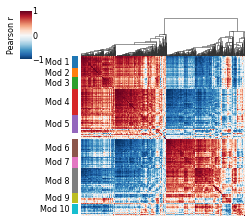

In [13]:
aver = misc_utils.local_correlation_plot(
            background_psi.loc[exon_list].T.corr().fillna(0), modules_pd.Module, bwow[1],
            mod_cmap='tab10', vmin=-1, vmax=1,
            z_cmap='RdBu_r', yticklabels=False,
    plot_name = 'plots/exon_modules.png'
)

In [24]:
(aver == modules_pd.loc[aver.index].Module).mean()

1.0

In [25]:
psix_object.modules

Mapt_1            1
Ndrg4_1           1
Dbn1_1            1
Mapt_3            1
Gabrg2_1          1
                 ..
Dlg4_3            1
Hnrnpd_nmdSE_1    8
Oaz2_1            6
Dmtf1_7           6
Arfgap1_5         2
Name: Module, Length: 798, dtype: int64

In [21]:
modules_pd.loc[aver.index].Module

Slc30a9_1        1
Slc30a9_2        1
Cnot2_nmdSE_1    1
Cnot2_nmdSE_2    1
Xpa_nmdSE_1      1
                ..
Mrpl55_1        -1
Trub2_2         -1
Ndufaf6_2       -1
Ncald_7         -1
Slc39a9_2       -1
Name: Module, Length: 798, dtype: int64

In [27]:
modules_pd.to_csv('psix_3D/modules_3D.tab.gz', sep='\t', index=True, header=True)

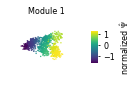

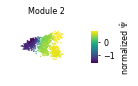

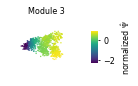

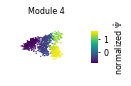

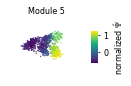

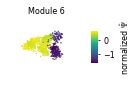

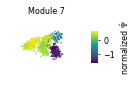

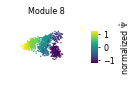

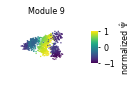

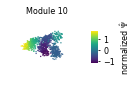

In [31]:
from scipy.stats import zscore

background_psi = psix_object.adata.uns['neighbors_psi'].T

for mod in range(1, 11):
    
    mad_df = pd.DataFrame()
    for exon in modules_pd.index[modules_pd.Module==mod]:
        mad_df[exon] = zscore(background_psi.loc[exon])
    mad_df.index= psix_object.adata.uns['psi'].index
    
    fig = plt.figure(figsize=(4.5*cm, 3*cm))
    ax = fig.add_subplot(111, projection='3d')
    ax.patch.set_visible(False)

    #     ax.set_xlabel('PC 1')
    #     ax.set_ylabel('PC 2')
    #     ax.set_zlabel('PC 3')


    sc = ax.scatter(psix_object.latent.PC_1, 
                    psix_object.latent.PC_2,
                    psix_object.latent.PC_3,
                    c=mad_df.mean(axis=1), cmap='viridis', s=2, alpha=0.9, linewidth=0)

    cb = plt.colorbar(sc, shrink = 0.5, aspect=5)
    cb.set_label(label='normalized $\hat{\Psi}$',size=8)
    cb.ax.tick_params(labelsize=8, length=2)

    cb.outline.set_visible(False)


    plt.title('Module '+str(mod), fontsize=8)
    #     if x == 3:
    #         plt.xlabel('PC 1', fontsize=18)
    #     if y == 0:
    #         plt.ylabel('PC 2', fontsize=18)


    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    # Now set color to white (or whatever is "invisible")
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

    ax.axis("off")

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.tick_params(labelsize=0, length=0)
    ax.grid(False)
    plt.savefig('plots/module_'+str(mod), bbox_inches='tight', res=20000, dpi =2000)

In [76]:
motif_dir = '~/Network/Mouse/SplicingNetwork/L_score_events/meme_motifs/'
mouse_motifs_exons = pd.read_csv(motif_dir + 'mouse_rbp.exons.tab', sep='\t', index_col=0)
mouse_motifs_ase = pd.read_csv(motif_dir + 'mouse_rbp.ase.tab', sep='\t', index_col=0)

human_motifs_exons = pd.read_csv(motif_dir + 'human_rbp.exons.tab', sep='\t', index_col=0)
human_motifs_ase = pd.read_csv(motif_dir + 'human_rbp.ase.tab', sep='\t', index_col=0)

clip_dir = '~/Network/Mouse/SplicingNetwork/L_score_events/tiklova/'
mouse_clip_predicted = pd.read_csv(clip_dir + 'peaks_predicted_mRBP.tab', sep='\t', index_col=0)
mouse_clip_peaks = pd.read_csv(clip_dir + 'peaks_clip_tags.tab', sep='\t', index_col=0)

mouse_clip_predicted = (mouse_clip_predicted.loc[[x for x in mouse_clip_predicted.index if x[-3:]=='_se']] > 0).astype(int)
mouse_clip_peaks = (mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:]=='_se']] > 0).astype(int)

mouse_clip_predicted.index= [x[:-3] for x in mouse_clip_predicted.index if x[-3:]=='_se']
mouse_clip_peaks.index= [x[:-3] for x in mouse_clip_peaks.index if x[-3:]=='_se']

clip_dir = '~/Network/Mouse/SplicingNetwork/L_score_events/tiklova_hRBP/'
human_clip_predicted = pd.read_csv(clip_dir + 'peaks_predicted_hRBP.tab', sep='\t', index_col=0)

human_clip_predicted = (human_clip_predicted.loc[[x for x in human_clip_predicted.index if x[-3:]=='_se']] > 0).astype(int)
human_clip_predicted.index= [x[:-3] for x in human_clip_predicted.index if x[-3:]=='_se']

clip_dir = '~/Network/Mouse/SplicingNetwork/L_score_events/tiklova/'

mouse_clip_peaks = pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0)

mouse_clip_predicted = (mouse_clip_predicted.loc[[x for x in mouse_clip_predicted.index if x[-3:]=='_se']] > 0).astype(int)
mouse_clip_peaks = (mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:]=='_se']] > 0).astype(int)

mouse_clip_predicted.index= [x[:-3] for x in mouse_clip_predicted.index if x[-3:]=='_se']
mouse_clip_peaks.index= [x[:-3] for x in mouse_clip_peaks.index if x[-3:]=='_se']


mouse_clip_peaks = pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0)
exon_lengths = pd.read_csv('~/Network/Mouse/SplicingNetwork/L_score_events/tiklova/exon_lengths.tab', sep='\t',
                           index_col=0, names=['exon', 'ase', 'length']).loc[mouse_clip_peaks.index]
exon_lengths.index == mouse_clip_peaks.index

mouse_clip_overlap = mouse_clip_peaks.divide(exon_lengths.length, axis=0)


mouse_clip_overlap = mouse_clip_overlap.loc[[x for x in mouse_clip_overlap.index if x[-3:]=='_se']]
mouse_clip_peaks = (mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:]=='_se']] > 0).astype(int)

mouse_clip_overlap.index= [x[:-3] for x in mouse_clip_overlap.index if x[-3:]=='_se']
mouse_clip_peaks.index= [x[:-3] for x in mouse_clip_peaks.index if x[-3:]=='_se']

exons_sorted = psix_results.loc[mouse_clip_overlap.index & psix_results.index].sort_values('psix_score').index[::-1]

list_modules = []

colores = ['forestgreen', 'indigo', 'brown', 'navy']

def enrichment_score(signal, exon_score=1):
    Nr = np.sum(signal)
    #exon_score = [1]*len(signal)
    denominator = len(signal) - np.sum(np.array(signal)>0)
    
    p_hit = []
    p_miss = []
    current_p_hit = 0
    current_p_miss = 0
    for i in range(len(signal)):
        if signal[i] > 0:
            current_p_hit += signal[i]/Nr
        else:
            current_p_miss += 1/denominator
        
        p_hit.append(current_p_hit)
        p_miss.append(current_p_miss)
        
    p_hit = np.array(p_hit)
    p_miss = np.array(p_miss)
    return p_hit-p_miss
    
def gsea(signal, permutations=2000):
    ES = np.max(enrichment_score(signal))
    ES_random = []
    for i in tqdm(range(permutations)):
        random_signal = np.random.choice(signal, len(signal), replace=False)
        ES_random.append(np.max(enrichment_score(random_signal)))
        
    ES_random = np.array(ES_random)
    p_val = (np.sum(ES_random >= ES)+1)/(permutations+1)
    return ES, p_val

# plt.plot(range(len(exons_sorted)),
#          enrichment_score(list(mouse_clip_overlap.loc[exons_sorted]['NOVA1'])))

In [77]:
import scipy.stats as ss
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests

def hyper_test(M, n, N, k):
    '''
    Calculates the hypergeometric test.
    
    Input:
      M: Population size (total exons tested)
      n: Successess in population (exons with p-value <= x)
      N: Sample size (exons selected)
      k: Successes in sample (selected exons with p-value <= x)
    Output:
      p_depleted: p-value of depletion from the hypergeometric test
      p_enriched: p-value of enrichment from the hypergeometric test
    '''
    hpd = hypergeom(M, n, N) # Hypergeometric distribution
    p_depleted = hpd.cdf(k)  # Get cummulative distribution up to k
    p_enriched = hpd.sf(k-1) # Survival function up to k-1 (1 - cdf(k-1))
    return p_depleted, p_enriched


def test_enrichment(binding, exon_cluster):
    M = len(binding)
    n = binding.sum()
    N = len(exon_cluster)
    k = binding.loc[exon_cluster].sum()
    p_depleted, p_enriched = hyper_test(M, n, N, k)
    
    enrichment = (k/N)/(n/M)
    
    if enrichment == 0:
        log_enrich = -3
    else:
        log_enrich = np.log2(enrichment)
        
    
    return p_enriched, p_depleted, log_enrich

In [78]:
clip_dir = '~/Network/Mouse/SplicingNetwork/psix_events/clip_seq/'

mouse_clip_peaks = (pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0) > 0).astype(int)
s1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s1']
s2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s2']
e1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e1']
e2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e2']




mouse_clip_families = pd.DataFrame()
mouse_clip_families['NOVA_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['NOVA1', 'NOVA2']].max(axis=1))

mouse_clip_families['RBFOX_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))

# mouse_clip_families['MBNL_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_se'] = np.array(mouse_clip_peaks.loc[se_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))

mouse_clip_families['SRSF_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
mouse_clip_families['SRSF_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 
                                                               ['SRSF3', 'SRSF4', 'SRSF5', 'SRSF6', 'SRSF7']].max(axis=1))
# mouse_clip_families['CELF'] = mouse_clip_peaks['CELF4']#.max(axis=1)
# mouse_clip_families['TARDBP'] = mouse_clip_peaks['TARDBP']#.max(axis=1)
# mouse_clip_families['LIN28A'] = mouse_clip_peaks['LIN28A']#.max(axis=1)
mouse_clip_families.index = [x[:-3] for x in mouse_clip_peaks.index if (x[-3:]=='_s1')]

modules = bwow[0]
modules = modules.loc[modules.index & mouse_clip_families.index]
mouse_clip_families = mouse_clip_families.loc[psix_results.index & mouse_clip_families.index]

print(mouse_clip_families.shape)

# mouse_clip_predicted = (mouse_clip_predicted.loc[[x for x in mouse_clip_predicted.index if x[-3:]=='_se']] > 0).astype(int)
# mouse_clip_peaks = (mouse_clip_peaks.loc[[x for x in mouse_clip_peaks.index if x[-3:]=='_se']] > 0).astype(int)

# mouse_clip_predicted.index= [x[:-3] for x in mouse_clip_predicted.index if x[-3:]=='_se']
# mouse_clip_peaks.index= [x[:-3] for x in mouse_clip_peaks.index if x[-3:]=='_se']

hyper_enrichment = pd.DataFrame()
hyper_pval_enrich = pd.DataFrame()
hyper_pval_deplete = pd.DataFrame()
for rbp in mouse_clip_families.columns:
    p_enrich = []
    p_deplete = []
    log_enrich = []
    for module in range(1, 11):
        enrichment = test_enrichment(mouse_clip_families[rbp], modules.index[(modules==module)])
        p_enrich.append(enrichment[0])
        p_deplete.append(enrichment[1])
        log_enrich.append(enrichment[2])
        
    hyper_enrichment[rbp] = log_enrich
    hyper_pval_enrich[rbp] = p_enrich
    hyper_pval_deplete[rbp] = p_deplete
    
hyper_enrichment.index = ['M'+ str(x) for x in range(1, 11)]
hyper_pval_enrich.index = ['M'+ str(x) for x in range(1, 11)]
hyper_pval_deplete.index = ['M'+ str(x) for x in range(1, 11)]
    
        
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(hyper_pval_enrich).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(10,-10)<=0.05)
hyper_enrich_significance.index = hyper_pval_enrich.index
hyper_enrich_significance.columns = hyper_pval_enrich.columns

labels = hyper_enrich_significance.copy()
for exon in hyper_enrich_significance.index:
    for rbp in hyper_enrich_significance.columns:
        if labels.loc[exon, rbp]:
            labels.loc[exon, rbp] = '*'
        else:
            labels.loc[exon, rbp] = ''
# from statsmodels.stats.multitest import multipletests

(2087, 12)


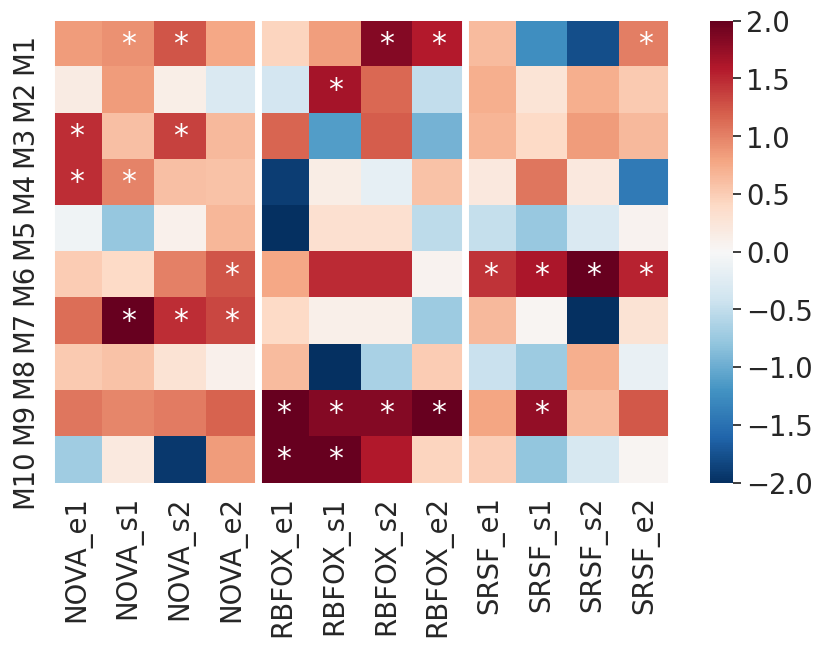

In [79]:
sns.set(font_scale=1.8)

fig = plt.figure(figsize=(10, 6))
ax = sns.heatmap(hyper_enrichment, cmap='RdBu_r', vmin=-2, vmax=2, annot=labels, fmt='')
for i in range(0, hyper_enrichment.shape[1] + 1, 4):
    ax.axvline(i, color='white', lw=5)
# for i in range(data.shape[1] + 1):
#     ax.axvline(i, color='white', lw=60)
plt.show()

# Expression modules (Hotspot)

In [19]:
import hotspot
from sklearn.preprocessing import StandardScaler

norm_expression = pd.read_csv('data/preprocess/tables/scone_norm_tpm.tab.gz', sep='\t', index_col=0)
latent = pd.read_csv('data/preprocess/tables/pc3_rd.tab.gz', sep='\t', index_col=0)

scaled_counts = pd.DataFrame(StandardScaler().fit_transform(norm_expression[latent.index].T).T)
scaled_counts.index = norm_expression.index
scaled_counts.columns = latent.index

hs = hotspot.Hotspot(norm_expression[latent.index], model='danb', latent=latent, 
                     umi_counts=np.ones(len(latent.index)))
hs.create_knn_graph(weighted_graph=False, n_neighbors=100)
hs_results = hs.compute_autocorrelations()

hs_genes = hs_results.loc[(hs_results.FDR < 0.001)].index # Select genes
local_correlations = hs.compute_local_correlations(hs_genes, jobs=25) # jobs for parallelization

  7%|▋         | 486/7091 [00:00<00:01, 4859.67it/s]

Computing pair-wise local correlation on 7091 features...


100%|██████████| 25137595/25137595 [38:33<00:00, 10865.02it/s] 


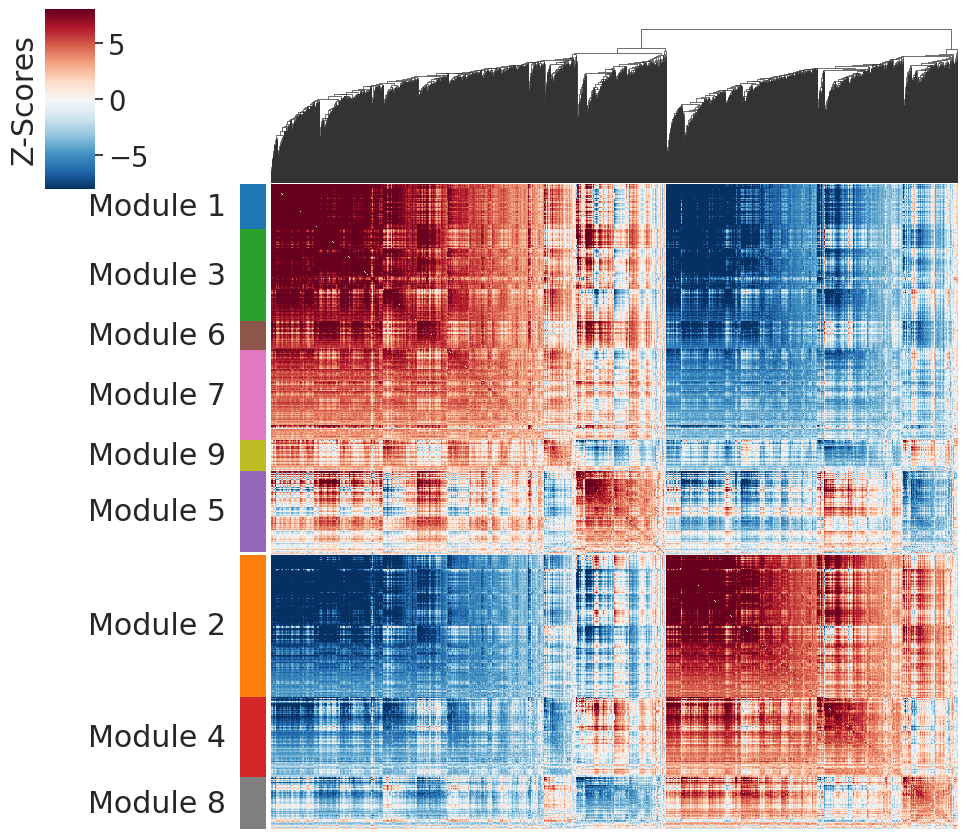

In [31]:
modules = hs.create_modules(
    min_gene_threshold=200, core_only=False, fdr_threshold=0.8
)

hs.plot_local_correlations()

In [5]:
# m90 = pd.read_csv('data/preprocess/tables/p90_pc2_rd.tab.gz', sep='\t', index_col=0)
# latent = pd.read_csv('data/preprocess/tables/pc3_rd.tab.gz', sep='\t', index_col=0)
# latent.loc[m90.index, ['PC_1', 'PC_3']].to_csv('data/preprocess/tables/p90_rd.tab.gz', sep='\t', index=True, header=True)

In [2]:
psix_object = psix.Psix()
psix_object.process_rnaseq(
        'data/preprocess/tables/p90_SE_counts_filtered.tab.gz',
        'data/preprocess/tables/p90_constitutive_introns_filtered.tab.gz',
        'data/preprocess/tables/p90_rsem_gene_tpm_filtered.tab.gz',
        minJR = 1,
        minCell=1,
        min_observed = 0.25)

psix_object.compute_psix_scores(latent='data/preprocess/tables/p90_rd.tab.gz', n_jobs=25, 
                                n_random_exons=2000, n_neighbors=30)

Obtaining psi tables...
Reading TPM and transforming to mRNA counts...
mariados
luigi
prueba 2


100%|██████████| 290/290 [00:00<00:00, 1602.85it/s]

Successfully processed RNA-seq data
cell-cell metric not found. Computing metric...
Successfully computed cell-cell metric
Computing Psix score in 2115 exons



100%|██████████| 2115/2115 [00:07<00:00, 284.46it/s]


Successfully computed Psix score of exons.
...

Estimating p-values. This might take a while...


100%|██████████| 25/25 [02:31<00:00,  6.05s/it]


Successfully estimated p-values


In [3]:
psix_object.compute_neighbors_psi(n_neighbors=30)

Successfully computed neighbors


In [4]:
np.sum((psix_object.psix_results.qvals <= 0.05) & (psix_object.psix_results.psix_score > 0))

66

In [5]:
psix_object.adata.uns['neighbors_psi'].T.to_csv('data/preprocess/tables/neighbors_psi_p90.tab.gz', sep='\t', 
                                                index=True, header=True)

psix_object.adata.uns['psi'].T.to_csv('data/preprocess/tables/psi_p90.tab.gz', sep='\t', 
                                                index=True, header=True)

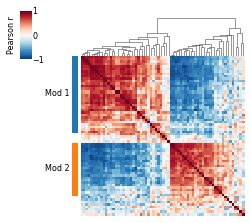

In [6]:
import sys
sys.path.insert(0, '/mnt/lareaulab/cfbuenabadn/psix_project/analysis_psix/utils/')
from misc_utils import *

psix_results = psix_object.psix_results

background_psi = psix_object.adata.uns['neighbors_psi'].mask(psix_object.adata.uns['psi'].isna()).T
exon_list = psix_results.loc[(psix_results.psix_score > 0) & (psix_results.qvals <= 0.05)].index

bwow = compute_modules(background_psi.loc[exon_list].T.corr().fillna(0), 
                min_gene_threshold=20, fdr_threshold=None, z_threshold=0.3, core_only=False)

aver = local_correlation_plot(
            background_psi.loc[exon_list].T.corr().fillna(0), bwow[0], bwow[1],
            mod_cmap='tab10', vmin=-1, vmax=1,
            z_cmap='RdBu_r', yticklabels=False,
    plot_name = 'plots/exon_modules_p90.png'
)

In [7]:
psix_object.save_psix_object('psix_object_p90/', overwrite=True)
pd.DataFrame(bwow[0]).to_csv('psix_object_p90/modules_p90.tab.gz', sep='\t', index=True, header=True)

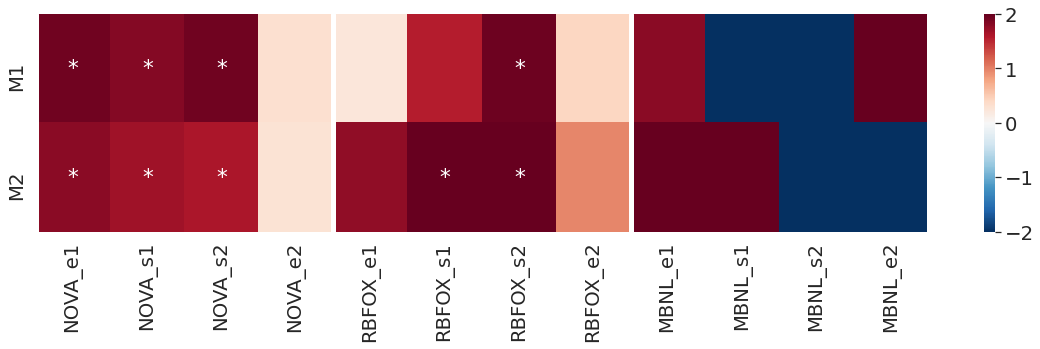

In [12]:
psix_results_p90 = pd.read_csv('psix_object_p90/psix_results.tab.gz', sep='\t', index_col=0)

clip_dir = '~/Network/Mouse/SplicingNetwork/psix_events/clip_seq/'


mouse_clip_peaks = (pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0) > 0).astype(int)
s1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s1']
s2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_s2']
e1_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e1']
e2_exons = [x for x in mouse_clip_peaks.index if x[-3:]=='_e2']




mouse_clip_families = pd.DataFrame()
mouse_clip_families['NOVA_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, ['NOVA1', 'NOVA2']].max(axis=1))
mouse_clip_families['NOVA_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['NOVA1', 'NOVA2']].max(axis=1))

mouse_clip_families['RBFOX_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))
mouse_clip_families['RBFOX_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['RBFOX1', 'RBFOX2', 'RBFOX3']].max(axis=1))

# mouse_clip_families['MBNL_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_se'] = np.array(mouse_clip_peaks.loc[se_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))
# mouse_clip_families['MBNL_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, ['MBNL1', 'MBNL2', 'MBNL1MBNL2']].max(axis=1))

mouse_clip_families['MBNL_e1'] = np.array(mouse_clip_peaks.loc[e1_exons, 
                                                               ['MBNL1', 'MBNL1MBNL2', 'MBNL2']].max(axis=1))
mouse_clip_families['MBNL_s1'] = np.array(mouse_clip_peaks.loc[s1_exons, 
                                                               ['MBNL1', 'MBNL1MBNL2', 'MBNL2']].max(axis=1))
mouse_clip_families['MBNL_s2'] = np.array(mouse_clip_peaks.loc[s2_exons, 
                                                               ['MBNL1', 'MBNL1MBNL2', 'MBNL2']].max(axis=1))
mouse_clip_families['MBNL_e2'] = np.array(mouse_clip_peaks.loc[e2_exons, 
                                                               ['MBNL1', 'MBNL1MBNL2', 'MBNL2']].max(axis=1))
# mouse_clip_families['CELF'] = mouse_clip_peaks['CELF4']#.max(axis=1)
# mouse_clip_families['TARDBP'] = mouse_clip_peaks['TARDBP']#.max(axis=1)
# mouse_clip_families['LIN28A'] = mouse_clip_peaks['LIN28A']#.max(axis=1)
mouse_clip_families.index = [x[:-3] for x in mouse_clip_peaks.index if (x[-3:]=='_s1')]



# mouse_clip_families.index = [x[:-3] for x in mouse_clip_peaks.index if (x[-3:]=='_s1')]

modules = bwow[0]#pd.read_csv('psix_object_p90/modules_p90.tab.gz', sep='\t', index_col=0).Module
modules = modules.loc[modules.index & mouse_clip_families.index]
mouse_clip_families = mouse_clip_families.loc[psix_results_p90.index & mouse_clip_families.index]

hyper_enrichment = pd.DataFrame()
hyper_pval_enrich = pd.DataFrame()
hyper_pval_deplete = pd.DataFrame()
for rbp in mouse_clip_families.columns:
    p_enrich = []
    p_deplete = []
    log_enrich = []
    for module in range(1, 3):
        enrichment = test_enrichment(mouse_clip_families[rbp], modules.index[(modules==module)])
        p_enrich.append(enrichment[0])
        p_deplete.append(enrichment[1])
        log_enrich.append(enrichment[2])
        
    hyper_enrichment[rbp] = log_enrich
    hyper_pval_enrich[rbp] = p_enrich
    hyper_pval_deplete[rbp] = p_deplete
    
hyper_enrichment.index = ['M'+ str(x) for x in range(1, 3)]
hyper_pval_enrich.index = ['M'+ str(x) for x in range(1, 3)]
hyper_pval_deplete.index = ['M'+ str(x) for x in range(1, 3)]
    
        
hyper_enrich_significance = pd.DataFrame(multipletests(np.array(hyper_pval_enrich).reshape(1,-1)[0], 
                                                       method='fdr_bh')[1].reshape(2,-2)<=0.1)
hyper_enrich_significance.index = hyper_pval_enrich.index
hyper_enrich_significance.columns = hyper_pval_enrich.columns

labels = hyper_enrich_significance.copy()
for exon in hyper_enrich_significance.index:
    for rbp in hyper_enrich_significance.columns:
        if labels.loc[exon, rbp]:
            labels.loc[exon, rbp] = '*'
        else:
            labels.loc[exon, rbp] = ''
# from statsmodels.stats.multitest import multipletests

sns.set(font_scale=1.8)

fig = plt.figure(figsize=(20, 4))
ax = sns.heatmap(hyper_enrichment, cmap='RdBu_r', vmin=-2, vmax=2, annot=labels, fmt='')
for i in range(0, hyper_enrichment.shape[1] + 1, 4):
    ax.axvline(i, color='white', lw=5)
# for i in range(data.shape[1] + 1):
#     ax.axvline(i, color='white', lw=60)
plt.show()

In [39]:
# mouse_clip_peaks = (pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0) > 0).astype(int)
mouse_clip_peaks = pd.read_csv(clip_dir + 'peaks_clip_tags_overlap_len.tab', sep='\t', index_col=0)

e1 = [x for x in mouse_clip_peaks.index if '_e1' in x]
e2 = [x for x in mouse_clip_peaks.index if '_e2' in x]
s1 = [x for x in mouse_clip_peaks.index if '_s1' in x]
s2 = [x for x in mouse_clip_peaks.index if '_s2' in x]
idx = [x[:-3] for x in mouse_clip_peaks.index if '_e1' in x]
mouse_clip_peaks_e1 = mouse_clip_peaks.loc[e1]
mouse_clip_peaks_e2 = mouse_clip_peaks.loc[e2]
mouse_clip_peaks_s1 = mouse_clip_peaks.loc[s1]
mouse_clip_peaks_s2 = mouse_clip_peaks.loc[s2]

mouse_clip_peaks_e1.index = idx
mouse_clip_peaks_e2.index = idx
mouse_clip_peaks_s1.index = idx
mouse_clip_peaks_s2.index = idx

max_overlap= pd.concat([mouse_clip_peaks_e1, mouse_clip_peaks_s1, mouse_clip_peaks_s2, mouse_clip_peaks_e2]).max(level=0)
is_bound = mouse_clip_peaks_e1 + mouse_clip_peaks_e2 + mouse_clip_peaks_s1 + mouse_clip_peaks_s2

In [41]:
psix_results_p90 = psix_object.psix_results

In [53]:
from numba import jit, njit

@njit
def enrichment_score(signal):
    
    Nr = 0
    for n in signal:
        if n < 0:
            Nr += -n
        else:
            Nr += n
#     Nr = np.sum(signal)
    
    suma = 0
    for s in signal:
        if s != 0:
            suma += 1
            
#     print(suma)
    
    missing = (len(signal) - suma)#np.sum(signal>0)
    denominator = missing
    
    p_hit = []
    p_miss = []
    current_p_hit = 0
    current_p_miss = 0
    for i in range(len(signal)):
        if signal[i] > 0:
            current_p_hit += signal[i]/Nr
        elif signal[i] < 0:
            current_p_hit += -signal[i]/Nr
        else:
            current_p_miss += 1/denominator
        
        p_hit.append(current_p_hit)
        p_miss.append(current_p_miss)
        
    pdiff = []
    for i in range(len(p_hit)):
        pdiff.append(p_hit[i]-p_miss[i])
        
    return pdiff#p_hit-p_miss
    
def gsea(signal, bound, permutations=1000):
    
    signal_bound = list(np.array(signal) * np.array((bound>0).astype(int)))
    
    ES = np.max(enrichment_score(signal_bound))
    ES_random = []
    for i in tqdm(range(permutations)):
        random_bound = np.random.choice(bound, len(signal), replace=False)
        
        random_signal = list(np.array(signal) * np.array((random_bound>0).astype(int)))
        
        ES_random.append(np.max(enrichment_score(random_signal)))
        
    ES_random = np.array(ES_random)
    p_val = (np.sum(ES_random >= ES)+1)/(permutations+1)
    return ES, p_val

In [55]:
es_pvals_list = []
p_pvals_list = []

es_score_list = []
p_score_list = []

es_rank_list = []
p_rank_list = []

for rbp in is_bound.columns:
    es, p = gsea(-np.log10(psix_results_p90.pvals), is_bound.loc[psix_results_p90.index][rbp])
    es_pvals_list.append(es)
    p_pvals_list.append(p)
    
    es, p = gsea(psix_results_p90.psix_score, is_bound.loc[psix_results_p90.index][rbp])
    es_score_list.append(es)
    p_score_list.append(p)
    
    es, p = gsea(np.ones(2115), is_bound.loc[psix_results_p90.index][rbp])
    es_rank_list.append(es)
    p_rank_list.append(p)
    
    
    
enrichment_pvals = pd.DataFrame()
enrichment_pvals['ES'] = es_pvals_list
enrichment_pvals['pvals'] = p_pvals_list
enrichment_pvals.index = is_bound.columns

enrichment_score = pd.DataFrame()
enrichment_score['ES'] = es_score_list
enrichment_score['pvals'] = p_score_list
enrichment_score.index = is_bound.columns

enrichment_rank = pd.DataFrame()
enrichment_rank['ES'] = es_rank_list
enrichment_rank['pvals'] = p_rank_list
enrichment_rank.index = is_bound.columns

100%|██████████| 1000/1000 [00:07<00:00, 133.71it/s]


In [56]:
enrichment_pvals['qvals'] = multipletests(enrichment_pvals['pvals'], method='fdr_bh')[1]
enrichment_score['qvals'] = multipletests(enrichment_score['pvals'], method='fdr_bh')[1]
enrichment_rank['qvals'] = multipletests(enrichment_rank['pvals'], method='fdr_bh')[1]

In [57]:
enrichment_pvals.loc[enrichment_pvals.qvals <= 0.05]

,ES,pvals,qvals
NOVA2,0.596182,0.000999,0.015984
MBNL2,0.745708,0.002997,0.031968
NOVA1,0.520201,0.000999,0.015984
RBFOX1,0.597474,0.003996,0.031968


In [62]:
neighbors_psi_p90 = pd.read_csv('data/preprocess/tables/neighbors_psi_p90.tab.gz', sep='\t', index_col=0)
psi_p90 = pd.read_csv('data/preprocess/tables/psi_p90.tab.gz', sep='\t', index_col=0)
latent_p90 = pd.read_csv('data/preprocess/tables/p90_pc2_rd.tab.gz', sep='\t', index_col=0)


In [78]:
norm_expression = pd.read_csv('data/preprocess/tables/scone_norm_tpm.tab.gz', sep='\t', index_col=0)


In [79]:
from scipy.stats import pearsonr, spearmanr
module_avg = pd.DataFrame()

for mod in range(1, 3):
    module_avg['module_' + str(mod)] = np.nanmean(zscore(psi_p90.loc[modules.index[modules == mod]], axis=1, 
                                             nan_policy='omit'), axis=0)
    
module_avg.index = psi_p90.columns
module_avg = module_avg.T


module_avg_corr = pd.DataFrame(np.zeros((len(pd.Index(['Nova1', 'Nova2', 'Rbfox1', 'Mbnl2'])& norm_expression.index), len(module_avg.index))), 
                               index = (pd.Index(['Nova1', 'Nova2', 'Rbfox1', 'Mbnl2'])& norm_expression.index), columns = module_avg.index)
for sf in tqdm(pd.Index(['Nova1', 'Nova2', 'Rbfox1', 'Mbnl2'])& norm_expression.index):
    for mod in module_avg.index:
        module_avg_corr.loc[sf, mod] = pearsonr(module_avg.loc[mod].fillna(module_avg.loc[mod].mean()),
                                                norm_expression.loc[sf, 
                                                                    module_avg.columns]
        )[0]

100%|██████████| 3/3 [00:00<00:00, 254.81it/s]


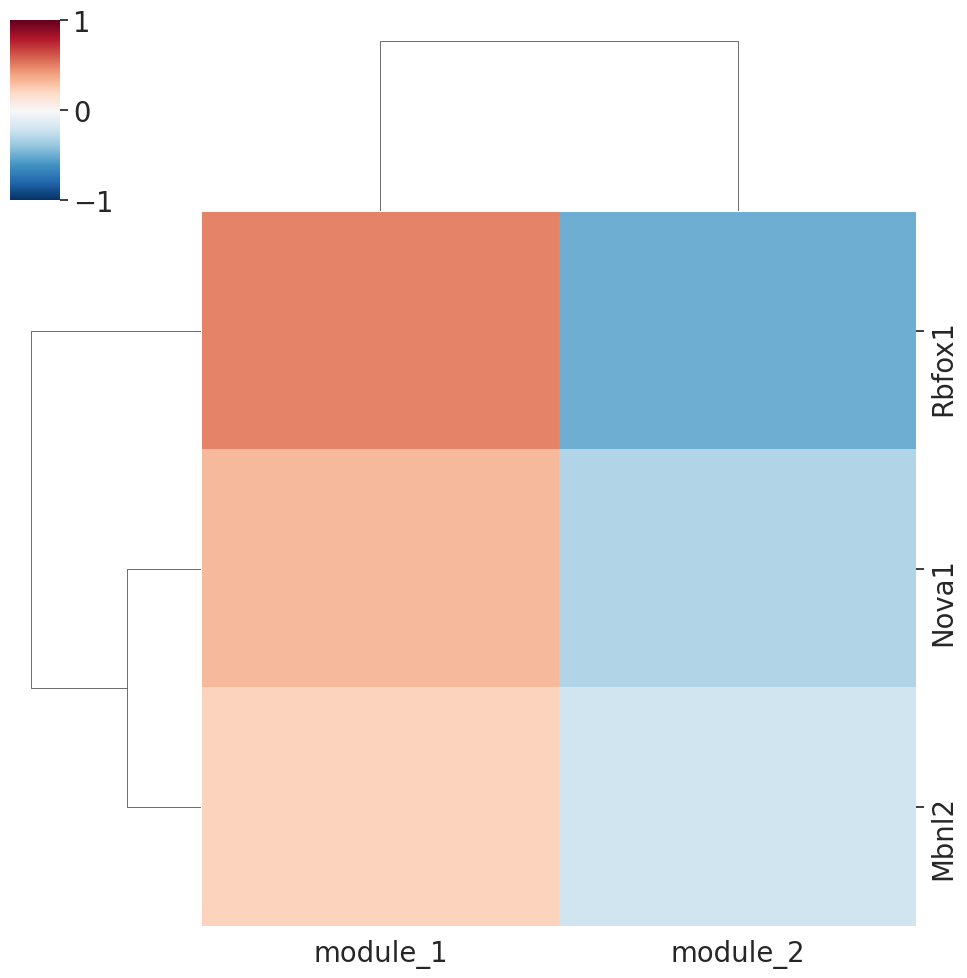

In [80]:
sns.clustermap(module_avg_corr, cmap='RdBu_r', vmin=-1, vmax=1)

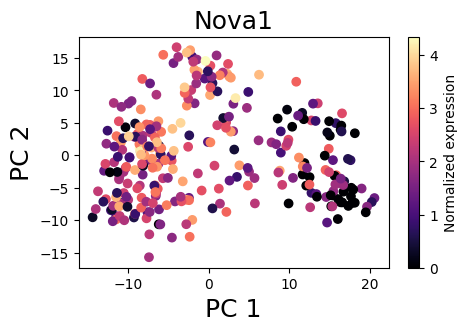

In [81]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

from scipy.stats import zscore
plt.figure(figsize=(5, 3))

sc = plt.scatter(latent_p90.PC_1, latent_p90.PC_2, 
    c=norm_expression.loc['Nova1', latent_p90.index], cmap='magma')
plt.colorbar(sc, label='Normalized expression')
plt.xlabel('PC 1', fontsize=18)
plt.ylabel('PC 2', fontsize=18)
plt.title('Nova1', fontsize=18)
plt.show()

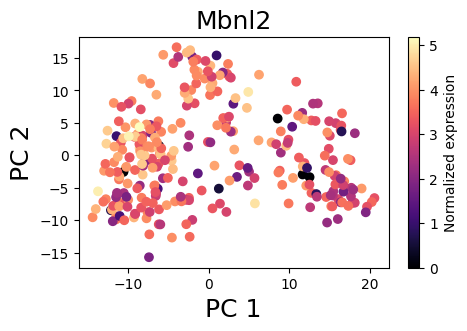

In [82]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

from scipy.stats import zscore
plt.figure(figsize=(5, 3))

sc = plt.scatter(latent_p90.PC_1, latent_p90.PC_2, 
    c=norm_expression.loc['Mbnl2', latent_p90.index], cmap='magma')
plt.colorbar(sc, label='Normalized expression')
plt.xlabel('PC 1', fontsize=18)
plt.ylabel('PC 2', fontsize=18)
plt.title('Mbnl2', fontsize=18)
plt.show()

In [97]:
modules_exons = bwow[0]

In [99]:
modules_exons

Nrxn1_4          1
Aplp2_3          1
Stxbp1_2         1
Cadps_7          1
Bnip2_nmdSE_1    1
                ..
Ociad1_5        -1
Wbp2_2           2
Uqcr10_1         1
Camk2b_5        -1
Tusc3_3          2
Name: Module, Length: 77, dtype: int64

In [84]:
modules_neuron_diversity.index[modules_neuron_diversity == 8]

Index(['Cadps_7', 'Aplp2_3', 'Kcnip1_1', 'Plpp1_2', 'Ank2_9', 'Epha5_3',
       'Cadps_2', 'Lysmd4_3', 'Resp18_1', 'Nktr_nmdSE_2', 'Ryr3_9',
       'Bnip2_nmdSE_1', 'Camk2b_9', 'Cuta_1', 'Osbpl9_10', 'Scn1a_3',
       'Clasp1_10', 'Prpf39_nmdSE_1', 'Rgs7_5', 'Slc4a10_2', 'Sorbs1_11',
       'Gripap1_5', 'Nek1_2', 'Rab28_1', 'Fbxo44_nmdSE_3', 'Acot8_1',
       'Slit2_4', 'Atat1_4', 'Erc2_8', 'Mtdh_2', 'Slc7a3_2', 'Cnksr2_2',
       'Csnk1d_3', 'Ythdf3_8', 'Stx3_nmdSE_1', 'Ppp4r1_nmdSE_1', 'Thap7_3',
       'Nptn_1', 'Rundc3b_2', 'Stag2_1', 'Tmem196_1', 'Hp1bp3_1', 'Sphkap_1',
       'Rhbdl1_1', 'Max_1', 'Rhbdl1_2', 'Srsf11_nmdSE_2', 'Cttn_14',
       'Rbfox1_8', 'Srsf2_1', 'Asph_5', 'Ssbp4_5', 'Thap7_7', 'Man2c1_8',
       'Dzank1_4', 'St7_10', 'Tpra1_5', 'Kansl1_2', 'Ptdss2_4', 'Spag9_10',
       'Comt_3', 'Prpf40a_nmdSE_2', 'Nol4_4', 'Ywhaz_2', 'Rnf152_1', 'Patz1_2',
       'Cttn_10', 'Mpg_nmdSE_1', 'Tmub2_1', 'Gripap1_7', 'Rita1_1',
       'Tbc1d9b_2', 'Nprl3_4', 'Flot1_1', 'Dctn6_4'

In [85]:
modules_neuron_diversity.index[modules_neuron_diversity == 9]

Index(['Morf4l2_7', 'Emc10_7', 'Meg3_2', 'Tecr_6', 'Sugp2_10', 'Gria2_nmdSE_2',
       'Snhg11_nmdSE_1', 'Pnkp_3', 'Gria2_1', 'Camk2g_5', 'Fance_2',
       'Tpd52l2_6', 'Dnajc6_2', 'Meg3_5', 'Robo2_2', 'Sorbs2_14',
       'Nkiras1_nmdSE_1', 'Eif5a_9', 'Nrxn2_16', 'Eif5a_4', 'Ptprf_9',
       'Wiz_nmdSE_1', 'Snhg11_nmdSE_2', 'Sorbs2_16', 'Meg3_9', 'Sh2b1_2',
       'Ctsa_4', 'Prpf40a_6', 'Ctsa_7', 'Gusb_3', 'Nrcam_5', 'Shmt2_1',
       'Odf2_4', 'Dnlz_1', 'Rmnd1_5', 'Gprin1_1', 'Zcrb1_2', 'Meg3_7',
       'Ntan1_7', 'Cbarp_nmdSE_2', 'Impdh1_2', 'Smarce1_9', 'Yif1a_2',
       'Stx3_5', 'Josd2_nmdSE_4', 'Kif1a_2', 'Josd2_9', 'Cbarp_nmdSE_1'],
      dtype='object')

In [90]:
bwow[0].index[bwow[0] == 1] & modules_neuron_diversity.index[modules_neuron_diversity == 8]

Index(['Aplp2_3', 'Cadps_7', 'Bnip2_nmdSE_1', 'Kcnip1_1', 'Epha5_3',
       'Stx3_nmdSE_1', 'Tmem196_1', 'Nek1_2', 'Slc4a10_2', 'Rab28_1'],
      dtype='object')

In [96]:
bwow[0].index[bwow[0] == 2] & modules_neuron_diversity.index[modules_neuron_diversity == 4]

Index(['Dusp12_1', 'Ank2_11', 'Dnal4_1', 'Arfrp1_9', 'Wbp2_2', 'Tusc3_3'], dtype='object')

Text(0.5, 1.0, 'Module confusion matrix')

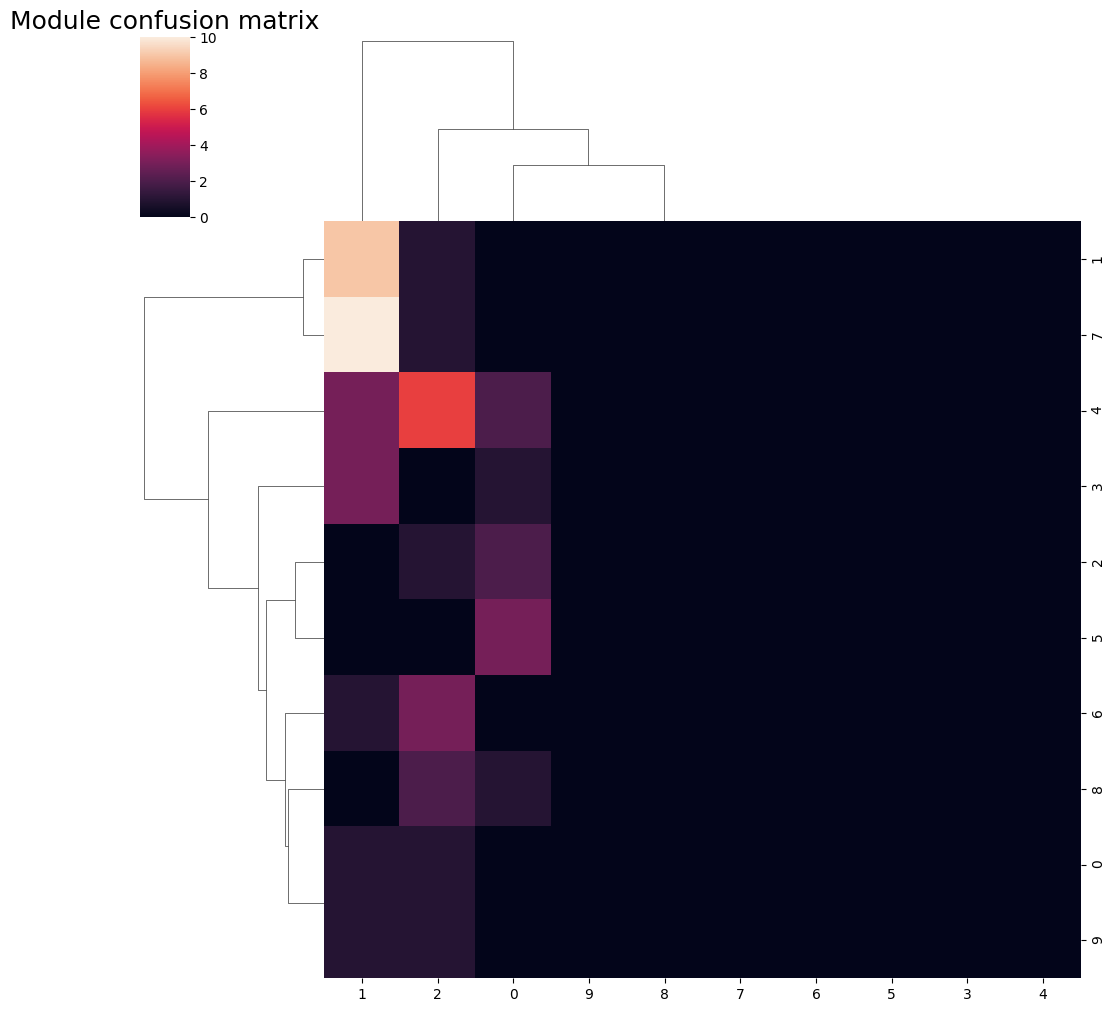

In [98]:
from sklearn.metrics import confusion_matrix
shared = modules_neuron_diversity.index & modules_exons.index
sns.clustermap(confusion_matrix(np.array(modules_neuron_diversity.loc[shared]),
                 np.array(modules_exons.loc[shared])))
plt.title('Module confusion matrix', fontsize=18)

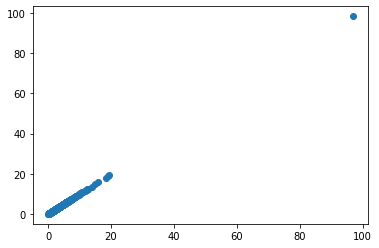

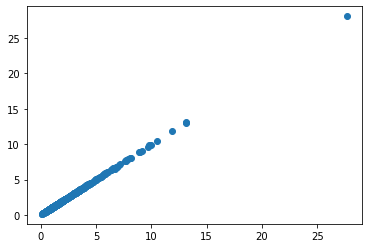

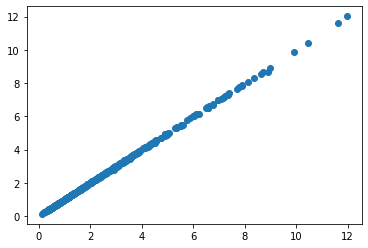

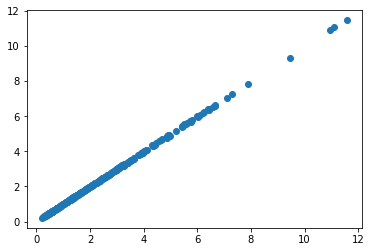

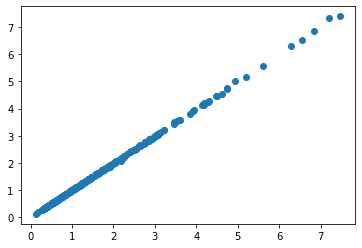

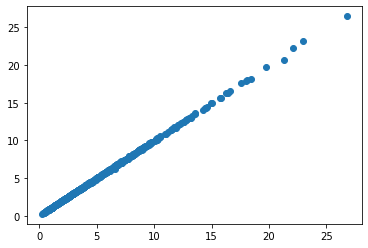

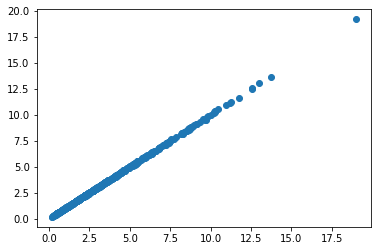

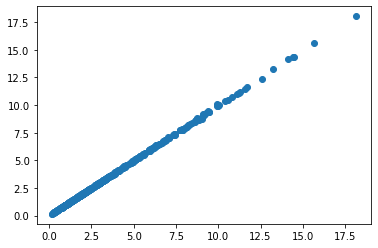

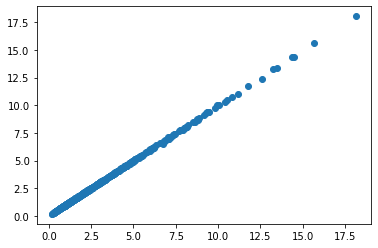

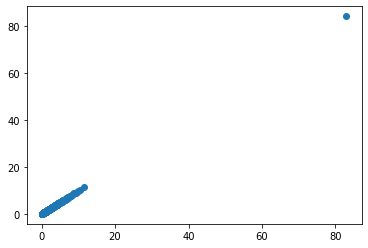

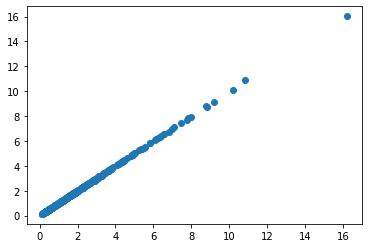

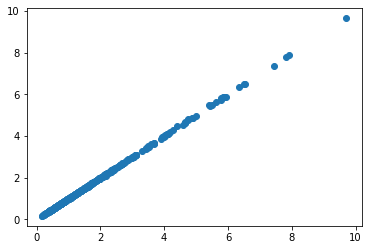

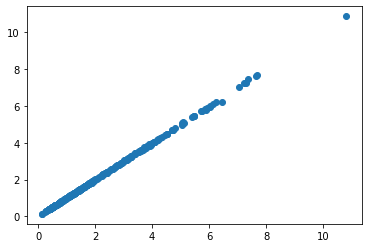

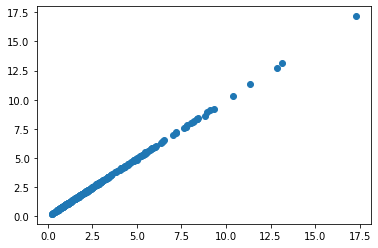

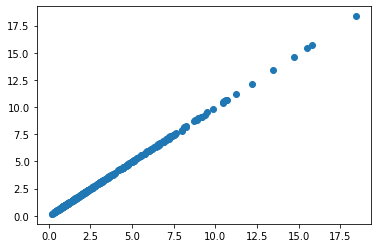

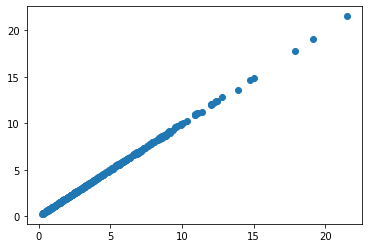

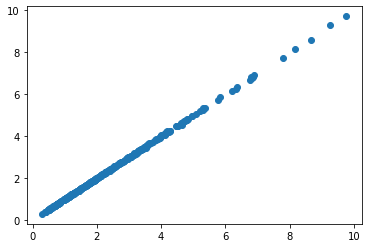

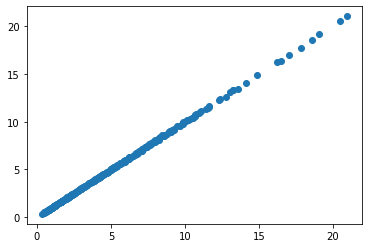

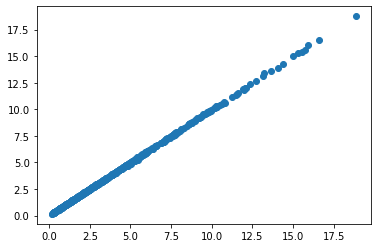

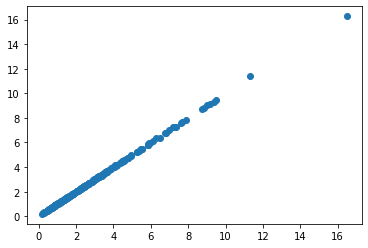

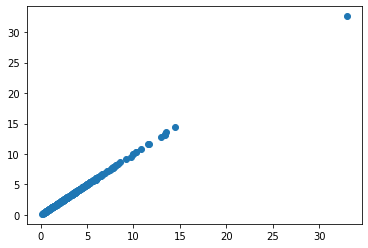

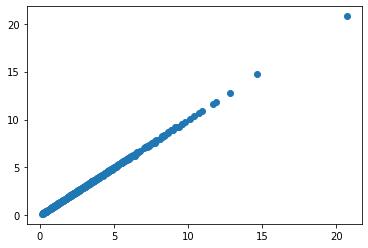

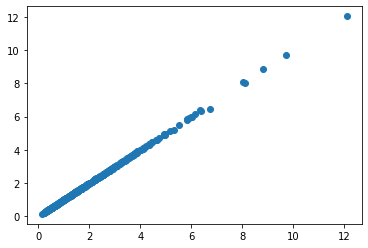

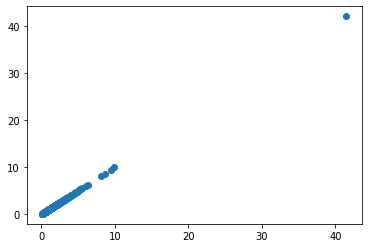

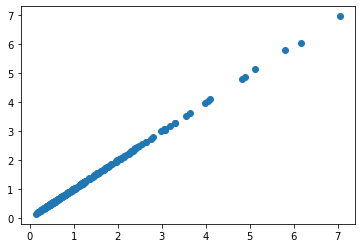

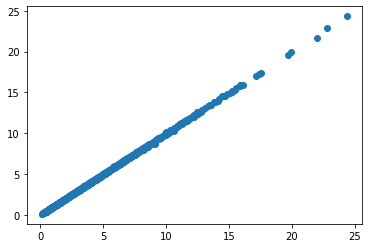

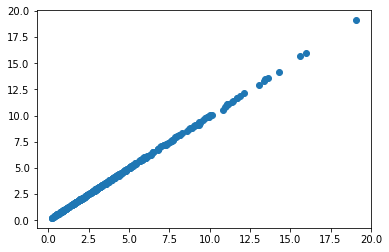

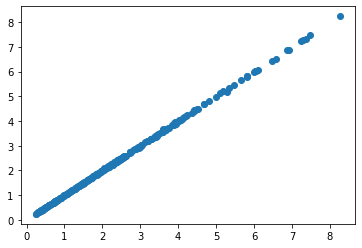

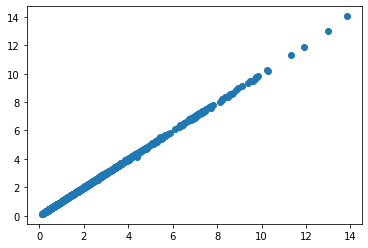

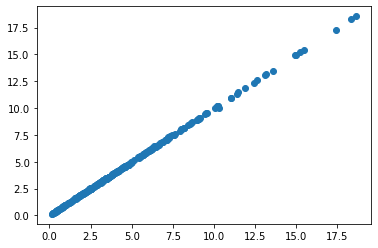

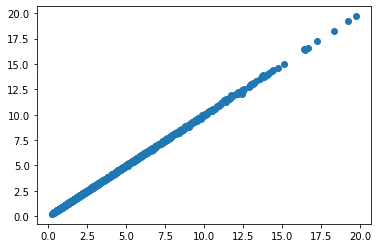

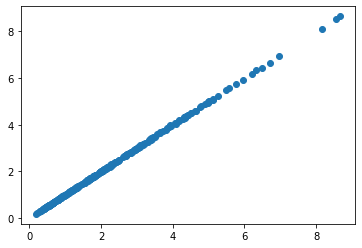

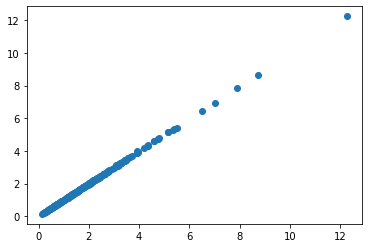

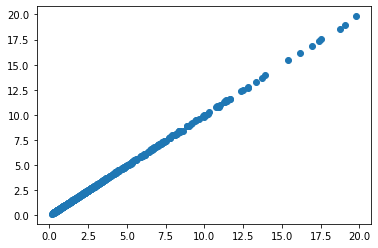

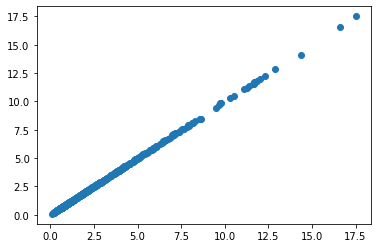

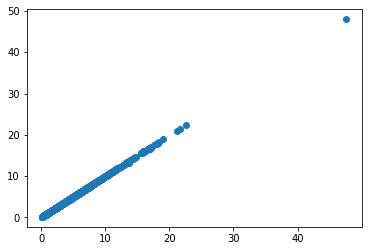

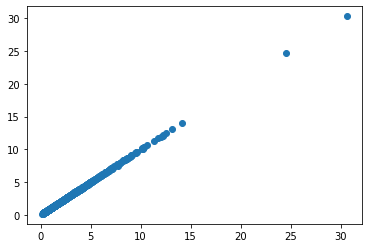

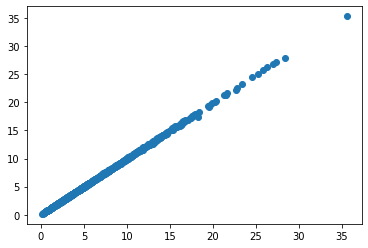

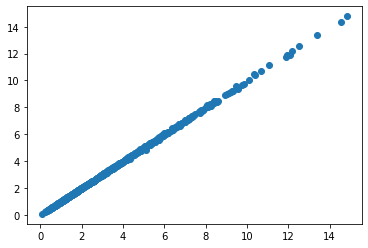

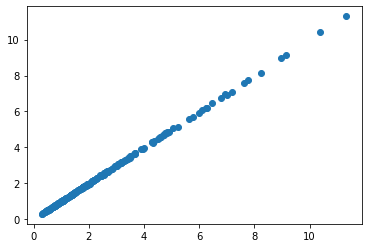

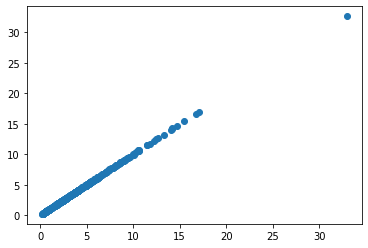

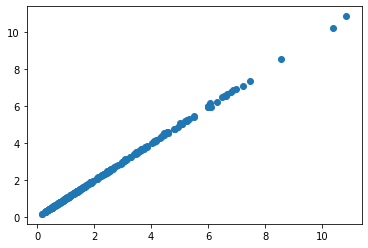

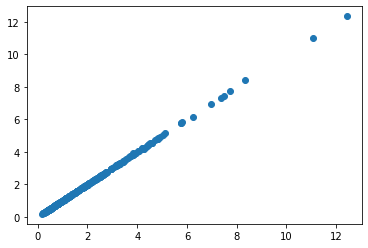

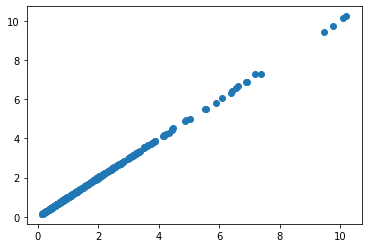

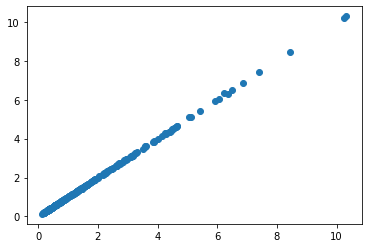

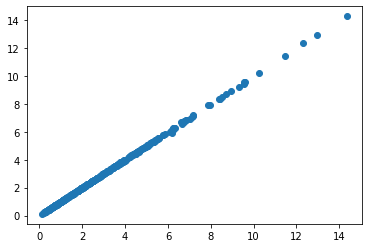

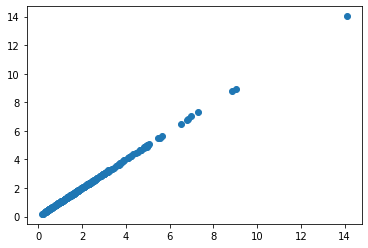

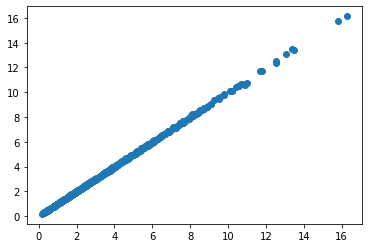

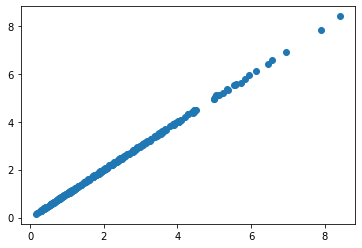

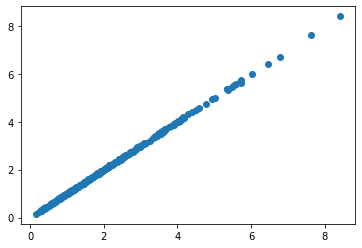

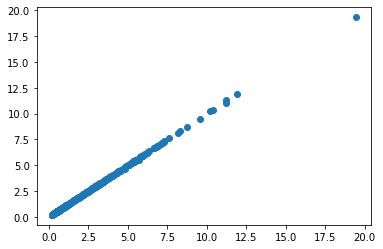

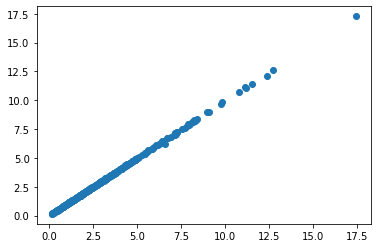

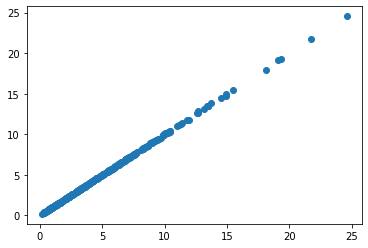

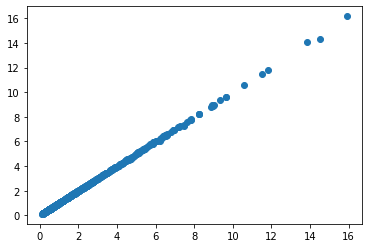

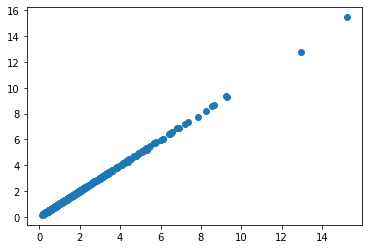

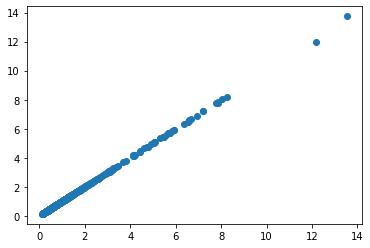

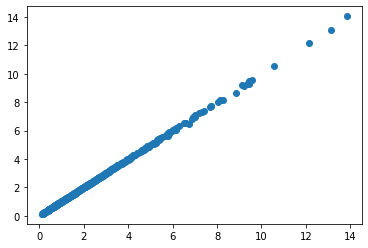

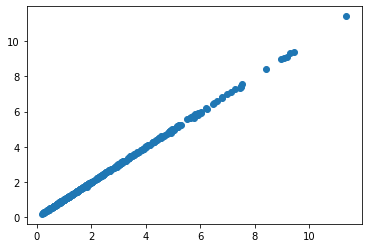

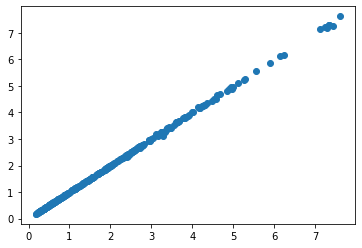

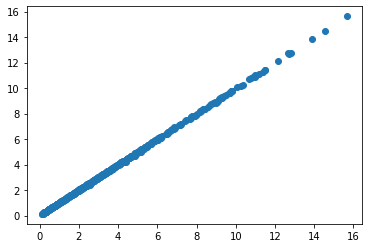

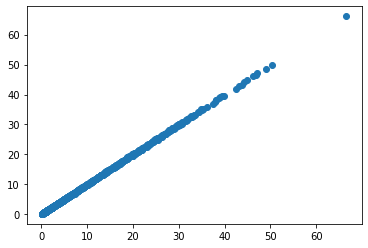

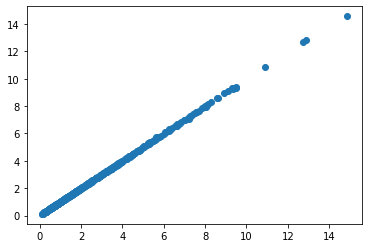

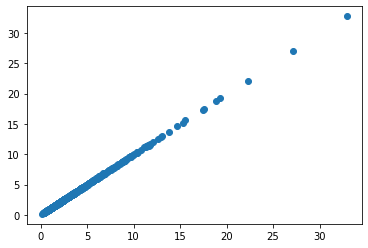

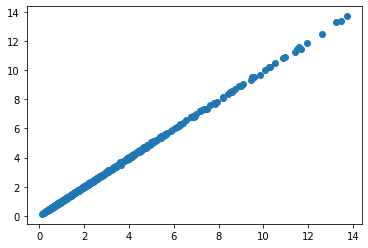

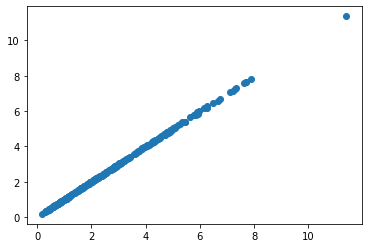

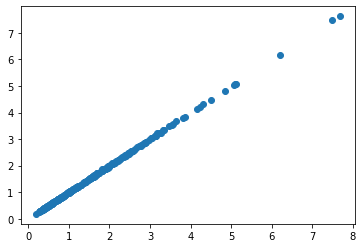

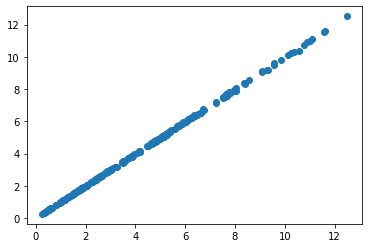

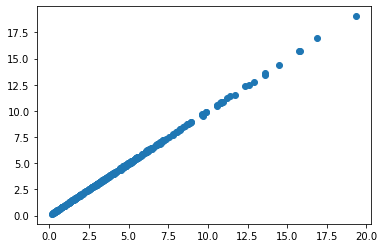

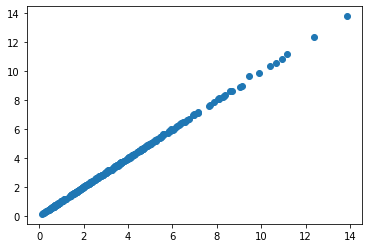

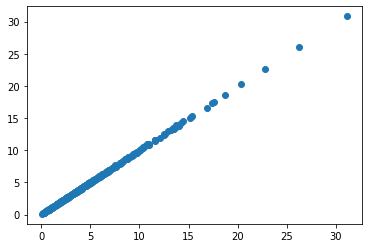

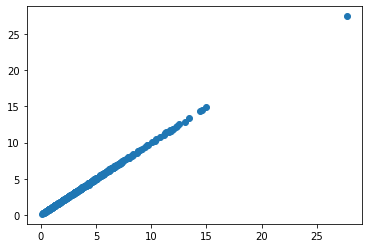

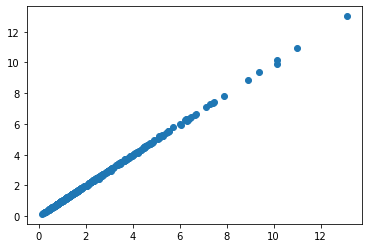

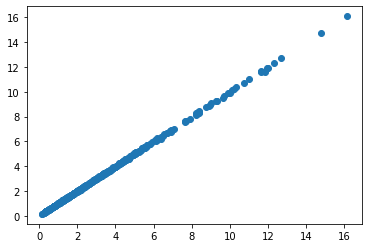

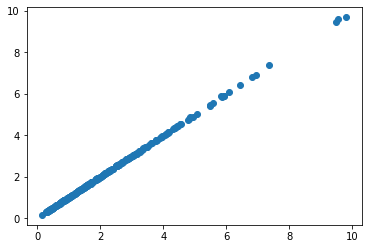

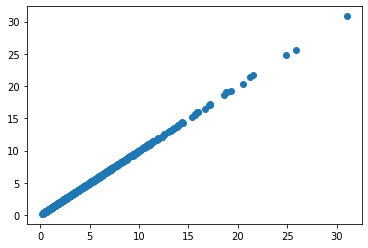

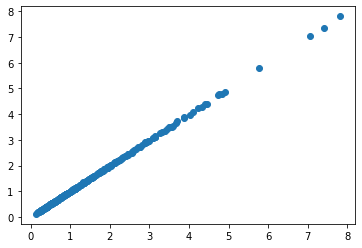

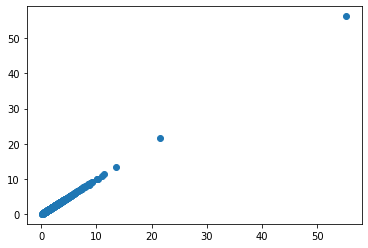

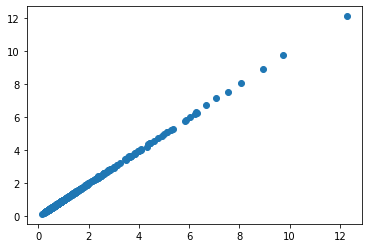

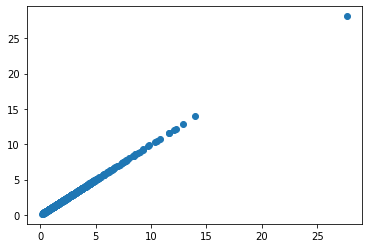

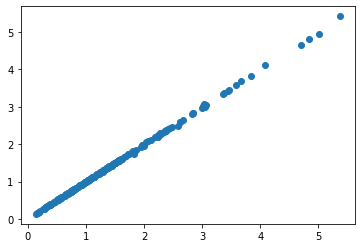

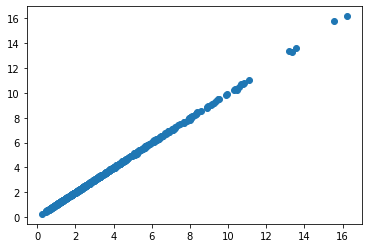

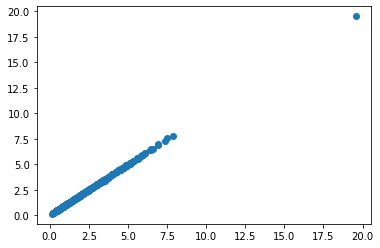

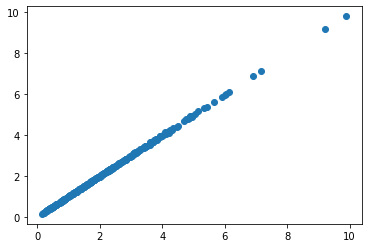

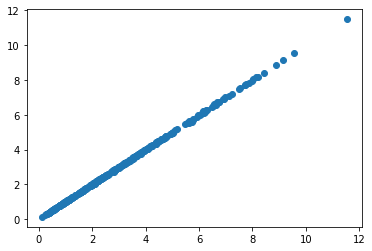

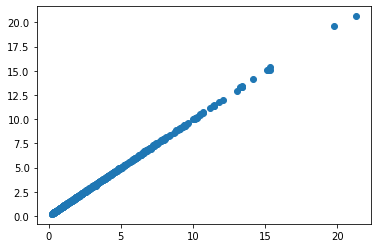

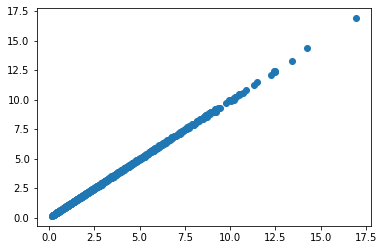

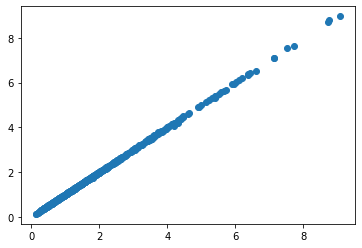

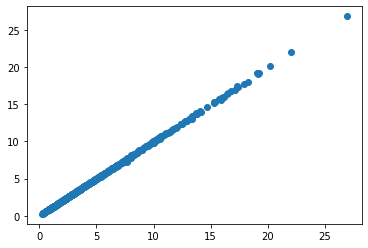

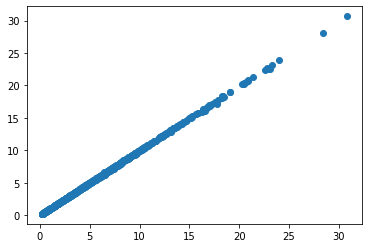

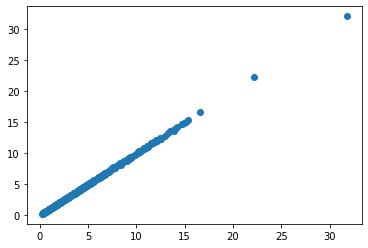

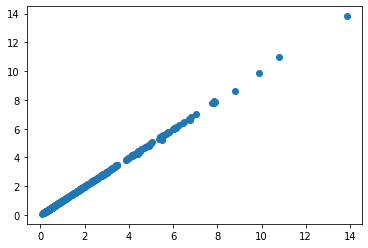

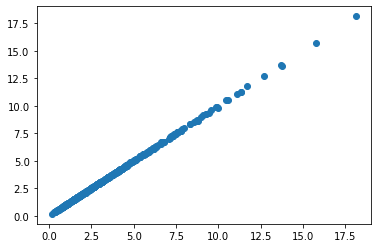

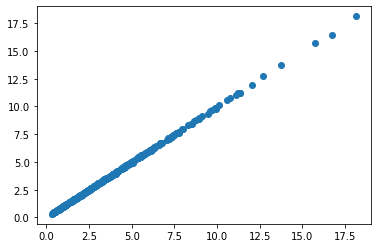

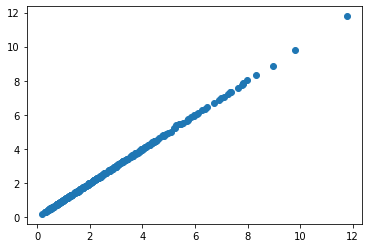

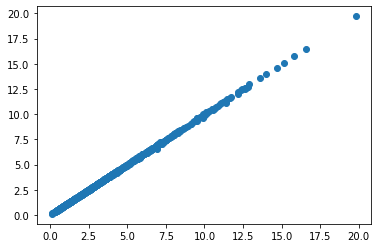

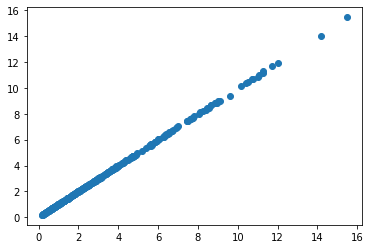

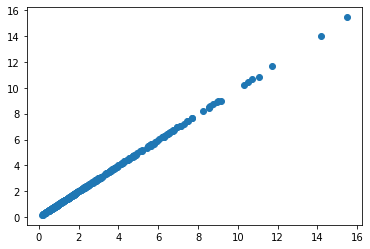

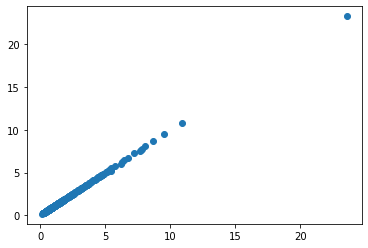

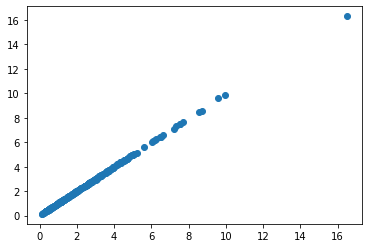

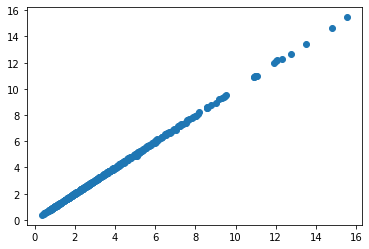

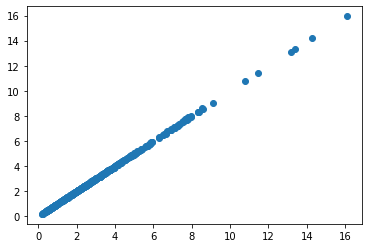

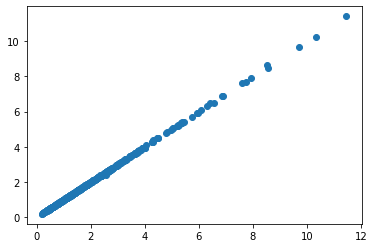

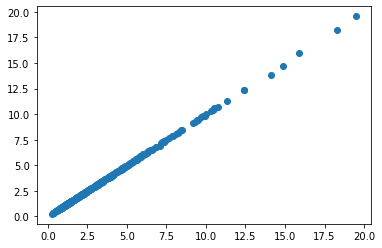

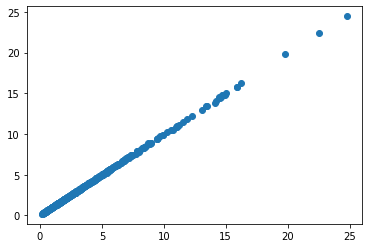

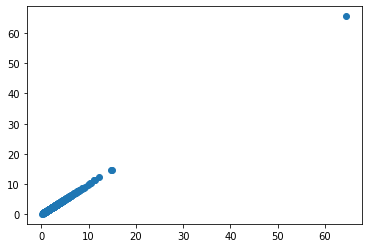

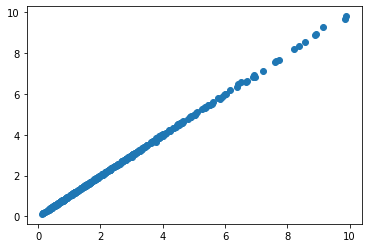

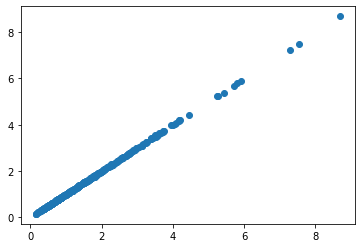

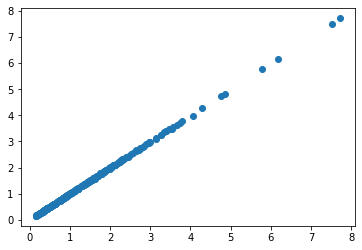

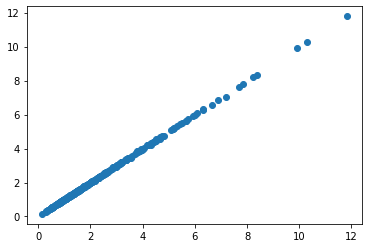

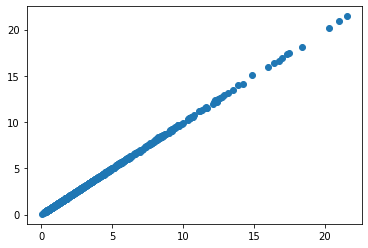

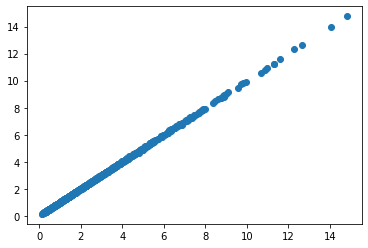

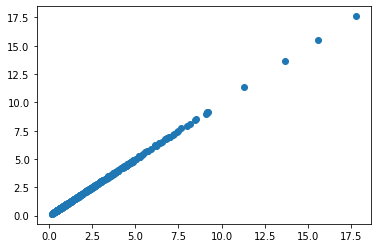

KeyboardInterrupt: 

In [10]:
mpe = pd.read_csv('/mnt/lareaulab/cfbuenabadn/data_sc_regulation/data_autocorrelation/tiklova_neurogenesis/mrna_per_event.tab', 
                 sep='\t', index_col=0)

from scipy.stats import pearsonr
for exon in (mpe.index & psix_object.adata.uns['mrna_per_event'].columns):
    plt.scatter(mpe.loc[exon, mpe.columns & psix_object.adata.uns['mrna_per_event'].index], psix_object.adata.uns['mrna_per_event'].loc[mpe.columns & psix_object.adata.uns['mrna_per_event'].index, exon])
    plt.show()

In [14]:
psix_object.adata.uns['mrna_per_event']['Mapt_1']

SRR7408400    23.853708
SRR7408401    27.144818
SRR7408404    18.609218
SRR7408413    14.875781
SRR7408414    17.978553
                ...    
SRR7410092    18.132365
SRR7410093    27.357133
SRR7410094    18.485137
SRR7410096    24.176691
SRR7410097    14.957838
Name: Mapt_1, Length: 1067, dtype: float64

In [13]:
psix_object.adata.uns['mrna']['Mapt']

SRR7408400    27.331206
SRR7408401    18.626561
SRR7408404    19.055606
SRR7408413    16.112505
SRR7408414    17.633982
                ...    
SRR7410092    17.116985
SRR7410093    11.072585
SRR7410094    19.277865
SRR7410096    27.696035
SRR7410097    14.012110
Name: Mapt, Length: 1067, dtype: float64

(array([  5., 122., 441., 310., 142.,  34.,   8.,   2.,   0.,   3.]),
 array([  647.44054519,  1974.75429817,  3302.06805115,  4629.38180413,
         5956.69555711,  7284.00931009,  8611.32306307,  9938.63681605,
        11265.95056903, 12593.26432201, 13920.57807499]),
 <a list of 10 Patch objects>)

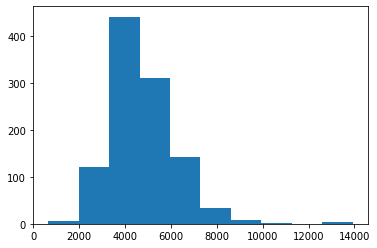

In [7]:
plt.hist(psix_object.adata.uns['mrna_per_event'].sum(axis=1))

In [3]:
psix_results = pd.read_csv('psix_3D/psix_results.tab.gz', sep='\t', index_col=0)


In [4]:
from tqdm import tqdm
gene_list = []
score_list = []
for idx, row in tqdm(psix_results.iterrows()):
    gene = idx.split('_')[0]
    if gene in gene_list:
        continue
    else:
        gene_list.append(gene)
        score_list.append(row.psix_score)

2087it [00:00, 7566.40it/s]


In [5]:
with open('psix.rnk', 'w') as fh:
    for i in range(len(gene_list)):
        line = gene_list[i] + '\t' + str(score_list[i]) + '\n'
        fh.write(line)

In [8]:
psix_object.compute_psix_scores(latent='data/preprocess/tables/pc3_rd.tab.gz', n_jobs=25, 
                                n_random_exons=1, n_neighbors=100, capture_efficiency = 0.1)
psix_scores_1 = psix_object.psix_results

  0%|          | 0/1067 [00:00<?, ?it/s]

cell-cell metric not found. Computing metric...


100%|██████████| 1067/1067 [00:00<00:00, 3210.20it/s]

Successfully computed cell-cell metric
Computing Psix score in 2087 exons



100%|██████████| 2087/2087 [00:26<00:00, 78.46it/s] 


Successfully computed Psix score of exons.
...

Estimating p-values. This might take a while...


100%|██████████| 25/25 [00:04<00:00,  5.60it/s]


Successfully estimated p-values


In [9]:
psix_object.compute_psix_scores(latent='data/preprocess/tables/pc3_rd.tab.gz', n_jobs=25, 
                                n_random_exons=1, n_neighbors=100, capture_efficiency = 0.2)
psix_scores_2 = psix_object.psix_results

psix_object.compute_psix_scores(latent='data/preprocess/tables/pc3_rd.tab.gz', n_jobs=25, 
                                n_random_exons=1, n_neighbors=100, capture_efficiency = 0.15)
psix_scores_15 = psix_object.psix_results

psix_object.compute_psix_scores(latent='data/preprocess/tables/pc3_rd.tab.gz', n_jobs=25, 
                                n_random_exons=1, n_neighbors=100, capture_efficiency = 0.05)
psix_scores_05 = psix_object.psix_results

psix_object.compute_psix_scores(latent='data/preprocess/tables/pc3_rd.tab.gz', n_jobs=25, 
                                n_random_exons=1, n_neighbors=100, capture_efficiency = 0.01)
psix_scores_01 = psix_object.psix_results

100%|██████████| 1067/1067 [00:00<00:00, 7647.03it/s]

cell-cell metric not found. Computing metric...
Successfully computed cell-cell metric
Computing Psix score in 2087 exons



100%|██████████| 2087/2087 [00:27<00:00, 75.95it/s] 


Successfully computed Psix score of exons.
...

Estimating p-values. This might take a while...


100%|██████████| 1067/1067 [00:00<00:00, 8416.06it/s]

Successfully estimated p-values
cell-cell metric not found. Computing metric...
Successfully computed cell-cell metric
Computing Psix score in 2087 exons



100%|██████████| 2087/2087 [00:26<00:00, 78.46it/s]  


Successfully computed Psix score of exons.
...

Estimating p-values. This might take a while...


100%|██████████| 1067/1067 [00:00<00:00, 8349.12it/s]

Successfully estimated p-values
cell-cell metric not found. Computing metric...
Successfully computed cell-cell metric
Computing Psix score in 2087 exons



100%|██████████| 2087/2087 [00:27<00:00, 77.05it/s] 


Successfully computed Psix score of exons.
...

Estimating p-values. This might take a while...


100%|██████████| 1067/1067 [00:00<00:00, 8372.80it/s]

Successfully estimated p-values
cell-cell metric not found. Computing metric...
Successfully computed cell-cell metric
Computing Psix score in 2087 exons



100%|██████████| 2087/2087 [00:26<00:00, 78.98it/s] 


Successfully computed Psix score of exons.
...

Estimating p-values. This might take a while...


100%|██████████| 25/25 [00:05<00:00,  4.87it/s]


Successfully estimated p-values


In [10]:
psix_object.compute_psix_scores(latent='data/preprocess/tables/pc3_rd.tab.gz', n_jobs=25, 
                                n_random_exons=1, n_neighbors=100, capture_efficiency = 0.25)
psix_scores_25 = psix_object.psix_results


psix_object.compute_psix_scores(latent='data/preprocess/tables/pc3_rd.tab.gz', n_jobs=25, 
                                n_random_exons=1, n_neighbors=100, capture_efficiency = 0.3)
psix_scores_3 = psix_object.psix_results

psix_object.compute_psix_scores(latent='data/preprocess/tables/pc3_rd.tab.gz', n_jobs=25, 
                                n_random_exons=1, n_neighbors=100, capture_efficiency = 0.35)
psix_scores_35 = psix_object.psix_results

psix_object.compute_psix_scores(latent='data/preprocess/tables/pc3_rd.tab.gz', n_jobs=25, 
                                n_random_exons=1, n_neighbors=100, capture_efficiency = 0.4)
psix_scores_4 = psix_object.psix_results

psix_object.compute_psix_scores(latent='data/preprocess/tables/pc3_rd.tab.gz', n_jobs=25, 
                                n_random_exons=1, n_neighbors=100, capture_efficiency = 0.45)
psix_scores_45 = psix_object.psix_results


100%|██████████| 1067/1067 [00:00<00:00, 8394.74it/s]

cell-cell metric not found. Computing metric...
Successfully computed cell-cell metric
Computing Psix score in 2087 exons



100%|██████████| 2087/2087 [00:27<00:00, 76.28it/s] 


Successfully computed Psix score of exons.
...

Estimating p-values. This might take a while...


100%|██████████| 1067/1067 [00:00<00:00, 7639.45it/s]

Successfully estimated p-values
cell-cell metric not found. Computing metric...
Successfully computed cell-cell metric
Computing Psix score in 2087 exons



100%|██████████| 2087/2087 [00:27<00:00, 74.97it/s] 


Successfully computed Psix score of exons.
...

Estimating p-values. This might take a while...


 83%|████████▎ | 883/1067 [00:00<00:00, 3476.25it/s]

Successfully estimated p-values
cell-cell metric not found. Computing metric...


100%|██████████| 1067/1067 [00:00<00:00, 4654.41it/s]

Successfully computed cell-cell metric
Computing Psix score in 2087 exons



100%|██████████| 2087/2087 [00:28<00:00, 73.55it/s] 


Successfully computed Psix score of exons.
...

Estimating p-values. This might take a while...


100%|██████████| 1067/1067 [00:00<00:00, 8257.30it/s]

Successfully estimated p-values
cell-cell metric not found. Computing metric...
Successfully computed cell-cell metric
Computing Psix score in 2087 exons



100%|██████████| 2087/2087 [00:29<00:00, 70.80it/s] 


Successfully computed Psix score of exons.
...

Estimating p-values. This might take a while...


100%|██████████| 1067/1067 [00:00<00:00, 8352.68it/s]

Successfully estimated p-values
cell-cell metric not found. Computing metric...
Successfully computed cell-cell metric
Computing Psix score in 2087 exons



100%|██████████| 2087/2087 [00:28<00:00, 73.02it/s] 


Successfully computed Psix score of exons.
...

Estimating p-values. This might take a while...


100%|██████████| 25/25 [00:04<00:00,  5.78it/s]


Successfully estimated p-values


In [11]:
psix_object.compute_psix_scores(latent='data/preprocess/tables/pc3_rd.tab.gz', n_jobs=25, 
                                n_random_exons=1, n_neighbors=100, capture_efficiency = 0.5)
psix_scores_5 = psix_object.psix_results

100%|██████████| 1067/1067 [00:00<00:00, 8190.58it/s]

cell-cell metric not found. Computing metric...
Successfully computed cell-cell metric
Computing Psix score in 2087 exons



100%|██████████| 2087/2087 [00:29<00:00, 71.79it/s] 


Successfully computed Psix score of exons.
...

Estimating p-values. This might take a while...


100%|██████████| 25/25 [00:04<00:00,  5.20it/s]


Successfully estimated p-values


In [12]:
scores_df = pd.DataFrame()
scores_df['0.5'] = psix_scores_5.psix_score
scores_df['0.45'] = psix_scores_45.psix_score
scores_df['0.4'] = psix_scores_4.psix_score
scores_df['0.35'] = psix_scores_35.psix_score
scores_df['0.3'] = psix_scores_3.psix_score
scores_df['0.25'] = psix_scores_25.psix_score
scores_df['0.2'] = psix_scores_2.psix_score
scores_df['0.15'] = psix_scores_15.psix_score
scores_df['0.1'] = psix_scores_1.psix_score
scores_df['0.05'] = psix_scores_05.psix_score
scores_df['0.01'] = psix_scores_01.psix_score

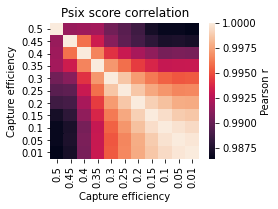

In [15]:
import seaborn as sns
fig = plt.figure(figsize=(8/2.4, 6/2.4))

sns.heatmap(scores_df.corr(), cbar_kws={'label': 'Pearson r'})
plt.xlabel('Capture efficiency')
plt.ylabel('Capture efficiency')

plt.title('Psix score correlation')

plt.savefig('plots/GO_corr.png', bbox_inches='tight', res=20000, dpi =2000)


Text(0.5, 1.0, 'Psix score correlation')

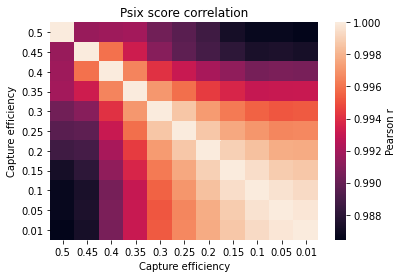

In [40]:
import seaborn as sns
sns.heatmap(scores_df.corr(), cbar_kws={'label': 'Pearson r'})
plt.xlabel('Capture efficiency')
plt.ylabel('Capture efficiency')

plt.title('Psix score correlation')

In [19]:
psix_scores_1.loc[psix_scores_1.psix_score > 0.01]

,psix_score,pvals,qvals
Mapt_1,2.709381,0.5,0.635119
Ndrg4_1,2.359093,0.5,0.635119
Dbn1_1,2.302729,0.5,0.635119
Mapt_3,1.964202,0.5,0.635119
Gabrg2_1,1.896363,0.5,0.635119
...,...,...,...
Lrrc14_3,0.010343,0.5,0.635119
Use1_2,0.010334,0.5,0.635119
Tomm5_2,0.010270,0.5,0.635119
Txnrd1_2,0.010131,0.5,0.635119


In [5]:
from sklearn.preprocessing import StandardScaler

norm_expression = pd.read_csv('data/preprocess/tables/scone_norm_tpm.tab.gz', sep='\t', index_col=0)
latent = pd.read_csv('data/preprocess/tables/pc3_rd.tab.gz', sep='\t', index_col=0)
from cell_metric import *

In [7]:
cc_metric = compute_cell_metric_light(
    latent, 
    n_neighbors=100, 
    weight_metric = True,
)

100%|██████████| 1067/1067 [00:00<00:00, 6549.03it/s]


In [23]:
from numba import jit
@jit(nopython=True)
def get_exon_neighbors_psi(observed_psi_array, cell_metric):
    psi_a_array = []
    for i in range(len(observed_psi_array)):
#         psi_o = observed_psi_array[i]
                    
#         psi_o_array.append(psi_o)

        neighbors = cell_metric[0][i]
        weights = cell_metric[1][i]

        psi_sum = 0
        weight_sum = 0
        for j in range(len(neighbors)):
            psi_n = observed_psi_array[neighbors[j]]
            if not np.isnan(psi_n):
                psi_sum += (psi_n * weights[j])
                weight_sum += weights[j]
        if weight_sum > 0:
            psi_a_array.append(psi_sum/weight_sum)
        else:
            psi_a_array.append(np.nan)
                
    return psi_a_array


def get_all_exons_neighbors(psi, cell_metric):
    
    neighbors_psi = []
    
    for exon_psi in tqdm(psi.T, leave=True, position=0):
        neighbors_psi.append(get_exon_neighbors_psi(exon_psi, cell_metric))
        
    return np.array(neighbors_psi)


In [30]:
background_expression = get_all_exons_neighbors(np.array(norm_expression[latent.index].T), cc_metric)

100%|██████████| 9457/9457 [00:02<00:00, 3406.23it/s]


In [31]:
background_expression = pd.DataFrame(background_expression)
background_expression.index = norm_expression.index
background_expression.columns = latent.index

In [35]:
background_expression.round(3).to_csv('data/preprocess/tables/smoothed_norm_expression.tab.gz', 
                             sep='\t', index=True, header=True)

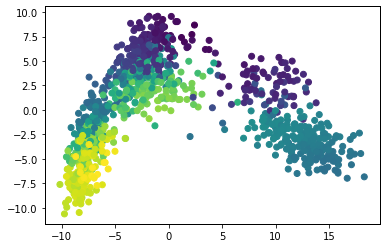

In [40]:
plt.scatter(latent.PC_1, latent.PC_2, c=background_expression.loc['Nova1'])